In [1]:
import os
import cv2
import numpy as np
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
from statistics import mean

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset

D:\Users\Alex\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import torchvision

import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [3]:
from functions_v2 import(import_train_folder_dataset_2, 
                      Data_2, 
                      plot_loss_accuracy, 
                      accuracy_given_set,
                      import_test_folder_dataset_2,
                      Data_test_2,
                      make_predictions,
                      save_predictions_as_csv,
                      save_model,
                      save_metrics)

# 1. Build your own convolutional neural network using pytorch

In [4]:
# Learning parameters.
epochs = 500 # Number of epochs to train the model
lr = 0.01 # Learning rate.
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)


TRAIN_BATCH_SIZE = 16
TEST_BATCH_SIZE = 8

checkpoints_save = 100 # Save after 100 epochs


model_checkpoints = "D:/Personal/Alex/Uni/MS IA/2 Curso/Fall 2022/Computer Vision/Project/Project 1/CheckPoints/"

cuda


In [5]:
#PyTorch - Building the Model
class ClassificationNet(nn.Module):
    def __init__(self):
        super(ClassificationNet, self).__init__()
        
        '''
        In dimension:              224 * 224 * 3 
        Out dimension Conv:        224 * 224 * 16
        Out dimension MaxPooling:  112 * 112 * 16
        '''
        self.cnn1_model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=9, stride=1, padding=4),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1)
        )
        self.maxpool1 = nn.MaxPool2d(2, stride=2)
        
        
        '''
        In dimension:              112 * 112 * 16
        Out dimension Conv:        112 * 112 * 32
        Out dimension MaxPooling:  56  * 56  * 32
        '''
        self.cnn2_model = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=9, stride=1, padding=4),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        )
        self.maxpool2 = nn.MaxPool2d(2, stride=2)
        
        '''
        In dimension:              56  * 56  * 32
        Out dimension Conv:        56  * 56  * 64
        Out dimension MaxPooling:  28  * 28  * 64
        '''
        self.cnn3_model = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        )
        self.maxpool3 = nn.MaxPool2d(2, stride=2)
        
        '''
        In dimension:              28  * 28  * 64
        Out dimension Conv:        28  * 28  * 128
        Out dimension MaxPooling:  14  * 14  * 128
        '''
        self.cnn4_model = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        )
        self.maxpool4 = nn.MaxPool2d(2, stride=2)
        
        '''
        In dimension:              14  * 14  * 128
        Out dimension Conv:        14  * 14  * 128
        Out dimension MaxPooling:  7  * 7  * 128
        '''
        self.cnn5_model = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        )
        self.maxpool5 = nn.MaxPool2d(2, stride=2)
        
        
        self.ffnn_model = nn.Sequential(
            nn.Linear(in_features=6272, out_features=512),
            nn.Dropout(0.4),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=4)
        )
        
        
        
    def forward(self, x): 
        

        # Convolution
        x = self.cnn1_model(x)
        x = F.relu(x) 
        # Max pooling
        x = self.maxpool1(x)
        
        
        # Convolution
        x = self.cnn2_model(x)
        x = F.relu(x) 
        # Max pooling
        x = self.maxpool2(x)
        
        
        # Convolution
        x = self.cnn3_model(x)
        x = F.relu(x) 
        # Max pooling
        x = self.maxpool3(x)
        
        
        # Convolution
        x = self.cnn4_model(x)
        x = F.relu(x) 
        # Max pooling
        x = self.maxpool4(x)
        
        
        # Convolution
        x = self.cnn5_model(x)
        x = F.relu(x) 
        # Max pooling
        x = self.maxpool5(x)
        
        
        x = torch.flatten(x,start_dim=1)
        #print("Flatten Out: ",x.shape)
        x = self.ffnn_model(x)
        #print("ffnn out: ",x.shape)
        x = torch.sigmoid(x)
        #print("Sigmoid Out: ",x.shape)
        return x

In [6]:
#PyTorch - Visualizing the Model
modelpy = ClassificationNet().to(device) # Get the model, and if there is a GPU use it
print("model created")
# Loss function.
criterion = nn.CrossEntropyLoss() # Set the loss function to cross entropy loss
# Optimizer.
optim = torch.optim.SGD(modelpy.parameters(), lr=lr)# , momentum=0.9, weight_decay=1e-3


# Check if checkpoint is available, if so, load it
epoch_check = 0
previous_time = 0
names = os.listdir(model_checkpoints)
for elem in names:
    if(elem=="model_ckpt.pth"):
        print("Loading save chackpoint")
        checkpoint = torch.load(model_checkpoints + "model_ckpt.pth")
        modelpy.load_state_dict(checkpoint['model_state_dict'])
        modelpy.to(device)
        optim.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch_check = checkpoint['epoch']
        criterion = checkpoint['loss']
        previous_time = checkpoint['time']
        print(f"Epoch of the checkpoint: {epoch_check}")


modelpy

model created


ClassificationNet(
  (cnn1_model): Sequential(
    (0): Conv2d(3, 16, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2_model): Sequential(
    (0): Conv2d(16, 32, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn3_model): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn4_model): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
 

In [7]:
# Model Parameters

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"Model Parameters: {count_parameters(modelpy)}")

Model Parameters: 4268820


# Load Data

In [8]:
# Path of the files
train_data_path = "D:/Personal/Alex/Uni/MS IA/2 Curso/Fall 2022/Artificial Intelligence/Projects/Project 1/data/Train"
test_data_path = "D:/Personal/Alex/Uni/MS IA/2 Curso/Fall 2022/Artificial Intelligence/Projects/Project 1/data/Test"

In [9]:
img_transform = transforms.Compose([transforms.ToPILImage(),
                                    transforms.RandomRotation((-20,20)),
                                    transforms.Resize((275, 275)),
                                    #transforms.CenterCrop((224, 224)),
                                    transforms.RandomCrop((224, 224)),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

img_transform_val = transforms.Compose([transforms.ToPILImage(),
                                        transforms.Resize((224, 224)),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

In [10]:
# Import the data into a resized 224x224 images
size_of_resized_img = (224,224) 
train_data, train_labels = import_train_folder_dataset_2(train_data_path, resized_side=size_of_resized_img)
print("Dim of Data: ", train_data.shape)
print("Dim of Lables: ", train_labels.shape)

Dim of Data:  (1149, 224, 224, 3)
Dim of Lables:  (1149,)


In [11]:
# Split into Train, Validation
X_train, X_val, y_train, y_val = train_test_split(train_data, train_labels, test_size=0.1, random_state=42)
print("Dim of Data: ", X_train.shape)
print("Dim of Lables: ", y_train.shape)
print("Dim of X_test: ", X_val.shape)
print("Dim of y_test: ", y_val.shape)

Dim of Data:  (1034, 224, 224, 3)
Dim of Lables:  (1034,)
Dim of X_test:  (115, 224, 224, 3)
Dim of y_test:  (115,)


In [12]:
# Create the dataset object
train_Dataset = Data_2(X_train, y_train, img_transform) # img_transform_2 img_transform
val_Dataset = Data_2(X_val, y_val, img_transform_val)

print("Train len: ",len(train_Dataset))
print("Val len: ",len(val_Dataset))

Train len:  1034
Val len:  115


In [13]:
# Create the dataloaders
train_loader = DataLoader(
    train_Dataset, 
    batch_size=TRAIN_BATCH_SIZE,             
    shuffle=True)

valid_loader = DataLoader(
    val_Dataset, 
    batch_size=TEST_BATCH_SIZE,
    shuffle=False
    )

In [14]:
print("Type of object: ",type(train_loader))

print()
print( 'Train Size: ' + str(len(train_loader)))
print( 'Validate Size: ' + str(len(valid_loader)))

print()
print("Content of one element: ",iter(train_loader).next())

print()
print("Type of one element: ", type(iter(train_loader).next()))
print("Length of one element: ", len(iter(train_loader).next()))

print()
print('Input tensors size: ' + str(iter(train_loader).next()[0].shape)) # Input: 16, 16875 | 16 train batch size, 16875 = 75x75 image dimension, 3 channels (colors) 
print('Label tensors size: ' + str(iter(train_loader).next()[1].shape)) # Label: 16 | 16 train Batch size


print()
print('Input tensors size: ' + str(iter(valid_loader).next()[0].shape)) # Input: 8, 16875 | 8 validation batch size, 16875 = 75x75 image dimension, 3 channels (colors) 
print('Label tensors size: ' + str(iter(valid_loader).next()[1].shape)) # Label: 8 | 8 validation Batch size


Type of object:  <class 'torch.utils.data.dataloader.DataLoader'>

Train Size: 65
Validate Size: 15

Content of one element:  [tensor([[[[-1.4158, -1.4158, -1.4158,  ...,  0.0741,  0.0398,  0.0398],
          [-1.4158, -1.3987, -1.4158,  ...,  0.0569,  0.0227,  0.0056],
          [-1.3987, -1.3987, -1.4158,  ...,  0.0398, -0.0116, -0.0116],
          ...,
          [-1.0390, -1.0219, -1.0733,  ..., -1.2617, -1.2788, -1.3130],
          [-0.9705, -0.9705, -1.0219,  ..., -1.3130, -1.2959, -1.2788],
          [-0.9020, -0.9192, -0.9363,  ..., -1.2959, -1.2959, -1.2617]],

         [[-1.0378, -1.0553, -1.0728,  ...,  0.1527,  0.1352,  0.1702],
          [-1.0378, -1.0378, -1.0728,  ...,  0.1527,  0.1176,  0.1352],
          [-1.0203, -1.0378, -1.0728,  ...,  0.1352,  0.1001,  0.1001],
          ...,
          [-0.5826, -0.5651, -0.6176,  ..., -0.6702, -0.6877, -0.7227],
          [-0.5126, -0.5126, -0.5651,  ..., -0.7227, -0.7052, -0.6877],
          [-0.4426, -0.4601, -0.4776,  ..., -0.70

# 2. Train your model using cow teat datasets (you may need to use  Google Colab (or Kaggle) with GPU to train your code) 


Epoch 1 of 500


100%|██████████| 15/15 [00:00<00:00, 16.56it/s]


train loss:  0.08692110414892378
Val loss:  0.17987490218618643
train accuracy:  0.41295938104448743
Val accuracy:  0.45217391304347826
Current time: 0.742 minutes. Time expected till completion: 370.160 minutes

Epoch 2 of 500


100%|██████████| 15/15 [00:01<00:00, 14.82it/s]


train loss:  0.08650946974523754
Val loss:  0.17900604061458422
train accuracy:  0.4245647969052224
Val accuracy:  0.45217391304347826
Current time: 1.051 minutes. Time expected till completion: 261.721 minutes

Epoch 3 of 500


100%|██████████| 15/15 [00:00<00:00, 17.14it/s]


train loss:  0.08609344362059691
Val loss:  0.1781222219052522
train accuracy:  0.42359767891682787
Val accuracy:  0.45217391304347826
Current time: 1.358 minutes. Time expected till completion: 225.034 minutes

Epoch 4 of 500


100%|██████████| 15/15 [00:00<00:00, 15.08it/s]


train loss:  0.08566685225562386
Val loss:  0.1771715029426243
train accuracy:  0.42359767891682787
Val accuracy:  0.45217391304347826
Current time: 1.680 minutes. Time expected till completion: 208.281 minutes

Epoch 5 of 500


100%|██████████| 15/15 [00:00<00:00, 16.38it/s]


train loss:  0.08517065696144473
Val loss:  0.17605327626933223
train accuracy:  0.4245647969052224
Val accuracy:  0.45217391304347826
Current time: 2.012 minutes. Time expected till completion: 199.224 minutes

Epoch 6 of 500


100%|██████████| 15/15 [00:00<00:00, 16.45it/s]


train loss:  0.08456940346575798
Val loss:  0.17462992046190345
train accuracy:  0.4274661508704062
Val accuracy:  0.45217391304347826
Current time: 2.329 minutes. Time expected till completion: 191.714 minutes

Epoch 7 of 500


100%|██████████| 15/15 [00:00<00:00, 16.96it/s]


train loss:  0.0837809438862238
Val loss:  0.17263520385908043
train accuracy:  0.42359767891682787
Val accuracy:  0.45217391304347826
Current time: 2.666 minutes. Time expected till completion: 187.794 minutes

Epoch 8 of 500


100%|██████████| 15/15 [00:00<00:00, 16.65it/s]


train loss:  0.08261349929831706
Val loss:  0.16950848413550335
train accuracy:  0.425531914893617
Val accuracy:  0.45217391304347826
Current time: 2.973 minutes. Time expected till completion: 182.826 minutes

Epoch 9 of 500


100%|██████████| 15/15 [00:00<00:00, 16.10it/s]


train loss:  0.0807085501847922
Val loss:  0.16424237541530443
train accuracy:  0.41876208897485495
Val accuracy:  0.45217391304347826
Current time: 3.292 minutes. Time expected till completion: 179.622 minutes

Epoch 10 of 500


100%|██████████| 15/15 [00:00<00:00, 16.63it/s]


train loss:  0.07781843509618733
Val loss:  0.15742190091506295
train accuracy:  0.42649903288201163
Val accuracy:  0.45217391304347826
Current time: 3.614 minutes. Time expected till completion: 177.064 minutes

Epoch 11 of 500


100%|██████████| 15/15 [00:00<00:00, 16.54it/s]


train loss:  0.07571815441378772
Val loss:  0.1541826579881751
train accuracy:  0.42359767891682787
Val accuracy:  0.45217391304347826
Current time: 3.951 minutes. Time expected till completion: 175.646 minutes

Epoch 12 of 500


100%|██████████| 15/15 [00:00<00:00, 16.79it/s]


train loss:  0.07511485579857743
Val loss:  0.15347646008367125
train accuracy:  0.4245647969052224
Val accuracy:  0.45217391304347826
Current time: 4.274 minutes. Time expected till completion: 173.828 minutes

Epoch 13 of 500


100%|██████████| 15/15 [00:00<00:00, 16.31it/s]


train loss:  0.07478019393389644
Val loss:  0.15318076506904935
train accuracy:  0.4274661508704062
Val accuracy:  0.45217391304347826
Current time: 4.591 minutes. Time expected till completion: 171.995 minutes

Epoch 14 of 500


100%|██████████| 15/15 [00:00<00:00, 16.11it/s]


train loss:  0.07477156959142629
Val loss:  0.15300357341766357
train accuracy:  0.42940038684719534
Val accuracy:  0.45217391304347826
Current time: 4.925 minutes. Time expected till completion: 170.979 minutes

Epoch 15 of 500


100%|██████████| 15/15 [00:00<00:00, 16.45it/s]


train loss:  0.07465038539362599
Val loss:  0.15290318468342656
train accuracy:  0.43036750483558994
Val accuracy:  0.45217391304347826
Current time: 5.251 minutes. Time expected till completion: 169.770 minutes

Epoch 16 of 500


100%|██████████| 15/15 [00:00<00:00, 17.22it/s]


train loss:  0.07438042120038886
Val loss:  0.15262821860935377
train accuracy:  0.42166344294003866
Val accuracy:  0.45217391304347826
Current time: 5.572 minutes. Time expected till completion: 168.546 minutes

Epoch 17 of 500


100%|██████████| 15/15 [00:01<00:00, 14.96it/s]


train loss:  0.07434597824712787
Val loss:  0.15230247041453485
train accuracy:  0.42649903288201163
Val accuracy:  0.45217391304347826
Current time: 5.906 minutes. Time expected till completion: 167.813 minutes

Epoch 18 of 500


100%|██████████| 15/15 [00:00<00:00, 16.18it/s]


train loss:  0.07422555276918688
Val loss:  0.15216444989909297
train accuracy:  0.4245647969052224
Val accuracy:  0.45217391304347826
Current time: 6.234 minutes. Time expected till completion: 166.923 minutes

Epoch 19 of 500


100%|██████████| 15/15 [00:00<00:00, 16.67it/s]


train loss:  0.07400854747576686
Val loss:  0.1518739067989847
train accuracy:  0.42359767891682787
Val accuracy:  0.45217391304347826
Current time: 6.563 minutes. Time expected till completion: 166.137 minutes

Epoch 20 of 500


100%|██████████| 15/15 [00:00<00:00, 17.10it/s]


train loss:  0.07373759974824622
Val loss:  0.1513300149337105
train accuracy:  0.4245647969052224
Val accuracy:  0.45217391304347826
Current time: 6.878 minutes. Time expected till completion: 165.072 minutes

Epoch 21 of 500


100%|██████████| 15/15 [00:00<00:00, 17.17it/s]


train loss:  0.07346095383974292
Val loss:  0.15079055143439252
train accuracy:  0.4245647969052224
Val accuracy:  0.45217391304347826
Current time: 7.196 minutes. Time expected till completion: 164.126 minutes

Epoch 22 of 500


100%|██████████| 15/15 [00:00<00:00, 16.67it/s]


train loss:  0.07309514791407484
Val loss:  0.1501606443653936
train accuracy:  0.4245647969052224
Val accuracy:  0.45217391304347826
Current time: 7.510 minutes. Time expected till completion: 163.172 minutes

Epoch 23 of 500


100%|██████████| 15/15 [00:00<00:00, 16.38it/s]


train loss:  0.07285906544506435
Val loss:  0.14987801261570144
train accuracy:  0.4245647969052224
Val accuracy:  0.45217391304347826
Current time: 7.828 minutes. Time expected till completion: 162.345 minutes

Epoch 24 of 500


100%|██████████| 15/15 [00:00<00:00, 17.07it/s]


train loss:  0.07267007364295207
Val loss:  0.1496511143186818
train accuracy:  0.4245647969052224
Val accuracy:  0.45217391304347826
Current time: 8.162 minutes. Time expected till completion: 161.874 minutes

Epoch 25 of 500


100%|██████████| 15/15 [00:00<00:00, 17.41it/s]


train loss:  0.0725256685362102
Val loss:  0.14995584591575292
train accuracy:  0.42649903288201163
Val accuracy:  0.45217391304347826
Current time: 8.479 minutes. Time expected till completion: 161.097 minutes

Epoch 26 of 500


100%|██████████| 15/15 [00:00<00:00, 17.08it/s]


train loss:  0.07253400580795406
Val loss:  0.149388485369475
train accuracy:  0.4284332688588008
Val accuracy:  0.45217391304347826
Current time: 8.805 minutes. Time expected till completion: 160.529 minutes

Epoch 27 of 500


100%|██████████| 15/15 [00:00<00:00, 16.93it/s]


train loss:  0.0722697171989677
Val loss:  0.14941980735115382
train accuracy:  0.4274661508704062
Val accuracy:  0.45217391304347826
Current time: 9.124 minutes. Time expected till completion: 159.837 minutes

Epoch 28 of 500


100%|██████████| 15/15 [00:01<00:00, 14.92it/s]


train loss:  0.07226947290062674
Val loss:  0.14920201923536217
train accuracy:  0.43133462282398455
Val accuracy:  0.45217391304347826
Current time: 9.459 minutes. Time expected till completion: 159.450 minutes

Epoch 29 of 500


100%|██████████| 15/15 [00:00<00:00, 17.20it/s]


train loss:  0.07201218247644214
Val loss:  0.1490584715552952
train accuracy:  0.42940038684719534
Val accuracy:  0.45217391304347826
Current time: 9.777 minutes. Time expected till completion: 158.788 minutes

Epoch 30 of 500


100%|██████████| 15/15 [00:00<00:00, 17.05it/s]


train loss:  0.07193796789161933
Val loss:  0.1485865795094034
train accuracy:  0.42649903288201163
Val accuracy:  0.45217391304347826
Current time: 10.092 minutes. Time expected till completion: 158.116 minutes

Epoch 31 of 500


100%|██████████| 15/15 [00:00<00:00, 17.04it/s]


train loss:  0.07169940721827273
Val loss:  0.14831494611242543
train accuracy:  0.425531914893617
Val accuracy:  0.45217391304347826
Current time: 10.404 minutes. Time expected till completion: 157.403 minutes

Epoch 32 of 500


100%|██████████| 15/15 [00:00<00:00, 15.77it/s]


train loss:  0.07148238238329122
Val loss:  0.1488585228505342
train accuracy:  0.42359767891682787
Val accuracy:  0.46956521739130436
Current time: 10.748 minutes. Time expected till completion: 157.193 minutes

Epoch 33 of 500


100%|██████████| 15/15 [00:00<00:00, 16.87it/s]


train loss:  0.07150941314734158
Val loss:  0.1480202026989149
train accuracy:  0.42649903288201163
Val accuracy:  0.48695652173913045
Current time: 11.066 minutes. Time expected till completion: 156.601 minutes

Epoch 34 of 500


100%|██████████| 15/15 [00:00<00:00, 17.01it/s]


train loss:  0.07124154629974808
Val loss:  0.1467597816301429
train accuracy:  0.42649903288201163
Val accuracy:  0.46956521739130436
Current time: 11.385 minutes. Time expected till completion: 156.039 minutes

Epoch 35 of 500


100%|██████████| 15/15 [00:00<00:00, 15.70it/s]


train loss:  0.07069215472477779
Val loss:  0.14442958520806354
train accuracy:  0.4458413926499033
Val accuracy:  0.4608695652173913
Current time: 11.712 minutes. Time expected till completion: 155.598 minutes

Epoch 36 of 500


100%|██████████| 15/15 [00:00<00:00, 17.18it/s]


train loss:  0.07038052025569938
Val loss:  0.14494836226753566
train accuracy:  0.47678916827852996
Val accuracy:  0.4956521739130435
Current time: 12.016 minutes. Time expected till completion: 154.876 minutes

Epoch 37 of 500


100%|██████████| 15/15 [00:00<00:00, 17.47it/s]


train loss:  0.07024794816970825
Val loss:  0.14473774795946867
train accuracy:  0.5145067698259188
Val accuracy:  0.5391304347826087
Current time: 12.318 minutes. Time expected till completion: 154.145 minutes

Epoch 38 of 500


100%|██████████| 15/15 [00:00<00:00, 16.80it/s]


train loss:  0.07034430547655206
Val loss:  0.14482987859974736
train accuracy:  0.5106382978723404
Val accuracy:  0.5391304347826087
Current time: 12.623 minutes. Time expected till completion: 153.474 minutes

Epoch 39 of 500


100%|██████████| 15/15 [00:00<00:00, 17.31it/s]


train loss:  0.06981889260806705
Val loss:  0.14373210461243338
train accuracy:  0.5125725338491296
Val accuracy:  0.5478260869565217
Current time: 12.936 minutes. Time expected till completion: 152.913 minutes

Epoch 40 of 500


100%|██████████| 15/15 [00:00<00:00, 17.04it/s]


train loss:  0.06982164698827659
Val loss:  0.147353268187979
train accuracy:  0.5338491295938105
Val accuracy:  0.6434782608695652
Current time: 13.246 minutes. Time expected till completion: 152.329 minutes

Epoch 41 of 500


100%|██████████| 15/15 [00:00<00:00, 16.37it/s]


train loss:  0.07022374072895751
Val loss:  0.14407055377960204
train accuracy:  0.5667311411992263
Val accuracy:  0.5739130434782609
Current time: 13.568 minutes. Time expected till completion: 151.894 minutes

Epoch 42 of 500


100%|██████████| 15/15 [00:00<00:00, 17.31it/s]


train loss:  0.06978605223578226
Val loss:  0.1446574532467386
train accuracy:  0.5609284332688588
Val accuracy:  0.6347826086956522
Current time: 13.874 minutes. Time expected till completion: 151.294 minutes

Epoch 43 of 500


100%|██████████| 15/15 [00:00<00:00, 17.08it/s]


train loss:  0.07018961516754771
Val loss:  0.1441959111586861
train accuracy:  0.5822050290135397
Val accuracy:  0.5652173913043478
Current time: 14.185 minutes. Time expected till completion: 150.752 minutes

Epoch 44 of 500


100%|██████████| 15/15 [00:00<00:00, 16.13it/s]


train loss:  0.06944940445270945
Val loss:  0.1448702739632648
train accuracy:  0.5541586073500967
Val accuracy:  0.5565217391304348
Current time: 14.490 minutes. Time expected till completion: 150.172 minutes

Epoch 45 of 500


100%|██████████| 15/15 [00:00<00:00, 17.08it/s]


train loss:  0.06928520224541714
Val loss:  0.14582871976106063
train accuracy:  0.5764023210831721
Val accuracy:  0.6434782608695652
Current time: 14.799 minutes. Time expected till completion: 149.630 minutes

Epoch 46 of 500


100%|██████████| 15/15 [00:00<00:00, 17.16it/s]


train loss:  0.06969856875777475
Val loss:  0.1440904358158941
train accuracy:  0.5715667311411993
Val accuracy:  0.6608695652173913
Current time: 15.104 minutes. Time expected till completion: 149.071 minutes

Epoch 47 of 500


100%|██████████| 15/15 [00:00<00:00, 17.34it/s]


train loss:  0.06966611610390462
Val loss:  0.14453298527261485
train accuracy:  0.5841392649903289
Val accuracy:  0.6260869565217392
Current time: 15.413 minutes. Time expected till completion: 148.559 minutes

Epoch 48 of 500


100%|██████████| 15/15 [00:00<00:00, 16.73it/s]


train loss:  0.06985268296540591
Val loss:  0.14349498126817786
train accuracy:  0.5889748549323017
Val accuracy:  0.6
Current time: 15.720 minutes. Time expected till completion: 148.032 minutes

Epoch 49 of 500


100%|██████████| 15/15 [00:00<00:00, 16.84it/s]


train loss:  0.06955802204299942
Val loss:  0.14344629308451776
train accuracy:  0.6054158607350096
Val accuracy:  0.6608695652173913
Current time: 16.034 minutes. Time expected till completion: 147.582 minutes

Epoch 50 of 500


100%|██████████| 15/15 [00:00<00:00, 17.14it/s]


train loss:  0.06964536279266992
Val loss:  0.14341555419175522
train accuracy:  0.6005802707930368
Val accuracy:  0.6347826086956522
Current time: 16.334 minutes. Time expected till completion: 147.009 minutes

Epoch 51 of 500


100%|██████████| 15/15 [00:00<00:00, 16.90it/s]


train loss:  0.06960780051045076
Val loss:  0.14280258831770523
train accuracy:  0.5822050290135397
Val accuracy:  0.6173913043478261
Current time: 16.636 minutes. Time expected till completion: 146.460 minutes

Epoch 52 of 500


100%|██████████| 15/15 [00:00<00:00, 16.53it/s]


train loss:  0.06939085585928055
Val loss:  0.14436659294625986
train accuracy:  0.586073500967118
Val accuracy:  0.6260869565217392
Current time: 16.953 minutes. Time expected till completion: 146.054 minutes

Epoch 53 of 500


100%|██████████| 15/15 [00:00<00:00, 17.46it/s]


train loss:  0.06941247816473188
Val loss:  0.143180469326351
train accuracy:  0.5938104448742747
Val accuracy:  0.6086956521739131
Current time: 17.264 minutes. Time expected till completion: 145.606 minutes

Epoch 54 of 500


100%|██████████| 15/15 [00:00<00:00, 16.97it/s]


train loss:  0.06904538266893974
Val loss:  0.14356555783230326
train accuracy:  0.5889748549323017
Val accuracy:  0.6173913043478261
Current time: 17.569 minutes. Time expected till completion: 145.107 minutes

Epoch 55 of 500


100%|██████████| 15/15 [00:00<00:00, 17.03it/s]


train loss:  0.06931405556271109
Val loss:  0.14415104596511177
train accuracy:  0.5851063829787234
Val accuracy:  0.5739130434782609
Current time: 17.879 minutes. Time expected till completion: 144.661 minutes

Epoch 56 of 500


100%|██████████| 15/15 [00:00<00:00, 16.46it/s]


train loss:  0.06933017637097859
Val loss:  0.14366982708806578
train accuracy:  0.5899419729206963
Val accuracy:  0.6695652173913044
Current time: 18.196 minutes. Time expected till completion: 144.269 minutes

Epoch 57 of 500


100%|██████████| 15/15 [00:00<00:00, 15.75it/s]


train loss:  0.06937332079535066
Val loss:  0.14358397463093633
train accuracy:  0.6083172147001934
Val accuracy:  0.6608695652173913
Current time: 18.525 minutes. Time expected till completion: 143.975 minutes

Epoch 58 of 500


100%|██████████| 15/15 [00:00<00:00, 17.04it/s]


train loss:  0.06913020365242802
Val loss:  0.1429776995078377
train accuracy:  0.5947775628626693
Val accuracy:  0.6260869565217392
Current time: 18.841 minutes. Time expected till completion: 143.580 minutes

Epoch 59 of 500


100%|██████████| 15/15 [00:00<00:00, 17.17it/s]


train loss:  0.06916287956431479
Val loss:  0.14194716215133668
train accuracy:  0.6102514506769826
Val accuracy:  0.5826086956521739
Current time: 19.154 minutes. Time expected till completion: 143.167 minutes

Epoch 60 of 500


100%|██████████| 15/15 [00:00<00:00, 16.79it/s]


train loss:  0.06904652063343926
Val loss:  0.14428140184153682
train accuracy:  0.5918762088974855
Val accuracy:  0.6260869565217392
Current time: 19.468 minutes. Time expected till completion: 142.767 minutes

Epoch 61 of 500


100%|██████████| 15/15 [00:00<00:00, 17.28it/s]


train loss:  0.06908131170318943
Val loss:  0.14295619518860528
train accuracy:  0.6083172147001934
Val accuracy:  0.6434782608695652
Current time: 19.771 minutes. Time expected till completion: 142.289 minutes

Epoch 62 of 500


100%|██████████| 15/15 [00:01<00:00, 14.50it/s]


train loss:  0.06908827749165622
Val loss:  0.1434993951216988
train accuracy:  0.6044487427466151
Val accuracy:  0.6521739130434783
Current time: 20.083 minutes. Time expected till completion: 141.874 minutes

Epoch 63 of 500


100%|██████████| 15/15 [00:00<00:00, 16.41it/s]


train loss:  0.06942700694100769
Val loss:  0.14360389864963033
train accuracy:  0.6015473887814313
Val accuracy:  0.6608695652173913
Current time: 20.415 minutes. Time expected till completion: 141.607 minutes

Epoch 64 of 500


100%|██████████| 15/15 [00:01<00:00, 13.25it/s]


train loss:  0.06910188268416163
Val loss:  0.14373038696206134
train accuracy:  0.6102514506769826
Val accuracy:  0.6608695652173913
Current time: 20.745 minutes. Time expected till completion: 141.325 minutes

Epoch 65 of 500


100%|██████████| 15/15 [00:00<00:00, 17.49it/s]


train loss:  0.06885295454953118
Val loss:  0.14307878691217174
train accuracy:  0.6131528046421664
Val accuracy:  0.6260869565217392
Current time: 21.073 minutes. Time expected till completion: 141.030 minutes

Epoch 66 of 500


100%|██████████| 15/15 [00:00<00:00, 17.59it/s]


train loss:  0.06910463124225402
Val loss:  0.142822876183883
train accuracy:  0.6112185686653772
Val accuracy:  0.6173913043478261
Current time: 21.373 minutes. Time expected till completion: 140.542 minutes

Epoch 67 of 500


100%|██████████| 15/15 [00:00<00:00, 17.35it/s]


train loss:  0.06911293433067646
Val loss:  0.144511848428975
train accuracy:  0.5938104448742747
Val accuracy:  0.6434782608695652
Current time: 21.672 minutes. Time expected till completion: 140.058 minutes

Epoch 68 of 500


100%|██████████| 15/15 [00:00<00:00, 16.94it/s]


train loss:  0.069192791699902
Val loss:  0.14367078594539476
train accuracy:  0.6121856866537717
Val accuracy:  0.6260869565217392
Current time: 21.968 minutes. Time expected till completion: 139.564 minutes

Epoch 69 of 500


100%|██████████| 15/15 [00:00<00:00, 16.94it/s]


train loss:  0.06902169685529787
Val loss:  0.1426056400589321
train accuracy:  0.6054158607350096
Val accuracy:  0.6
Current time: 22.263 minutes. Time expected till completion: 139.061 minutes

Epoch 70 of 500


100%|██████████| 15/15 [00:00<00:00, 17.15it/s]


train loss:  0.06917837613786443
Val loss:  0.1437414050102234
train accuracy:  0.6073500967117988
Val accuracy:  0.6521739130434783
Current time: 22.556 minutes. Time expected till completion: 138.560 minutes

Epoch 71 of 500


100%|██████████| 15/15 [00:00<00:00, 17.39it/s]


train loss:  0.06951718029477841
Val loss:  0.1429324906805287
train accuracy:  0.6073500967117988
Val accuracy:  0.6173913043478261
Current time: 22.852 minutes. Time expected till completion: 138.075 minutes

Epoch 72 of 500


100%|██████████| 15/15 [00:00<00:00, 17.37it/s]


train loss:  0.07060323226152121
Val loss:  0.14992004062818445
train accuracy:  0.5899419729206963
Val accuracy:  0.5739130434782609
Current time: 23.145 minutes. Time expected till completion: 137.584 minutes

Epoch 73 of 500


100%|██████████| 15/15 [00:00<00:00, 17.49it/s]


train loss:  0.07077366061782468
Val loss:  0.1446252791777901
train accuracy:  0.5947775628626693
Val accuracy:  0.6434782608695652
Current time: 23.438 minutes. Time expected till completion: 137.096 minutes

Epoch 74 of 500


100%|██████████| 15/15 [00:00<00:00, 16.98it/s]


train loss:  0.07012571991066407
Val loss:  0.14593998452891474
train accuracy:  0.6073500967117988
Val accuracy:  0.6521739130434783
Current time: 23.732 minutes. Time expected till completion: 136.622 minutes

Epoch 75 of 500


100%|██████████| 15/15 [00:00<00:00, 17.51it/s]


train loss:  0.0698711964908836
Val loss:  0.14548935890197753
train accuracy:  0.6054158607350096
Val accuracy:  0.6608695652173913
Current time: 24.027 minutes. Time expected till completion: 136.153 minutes

Epoch 76 of 500


100%|██████████| 15/15 [00:00<00:00, 17.59it/s]


train loss:  0.069220113223941
Val loss:  0.14530353235161822
train accuracy:  0.6015473887814313
Val accuracy:  0.6521739130434783
Current time: 24.322 minutes. Time expected till completion: 135.691 minutes

Epoch 77 of 500


100%|██████████| 15/15 [00:00<00:00, 17.15it/s]


train loss:  0.06902261380992498
Val loss:  0.14313251764877982
train accuracy:  0.620889748549323
Val accuracy:  0.6
Current time: 24.619 minutes. Time expected till completion: 135.242 minutes

Epoch 78 of 500


100%|██████████| 15/15 [00:00<00:00, 17.05it/s]


train loss:  0.06926345727199282
Val loss:  0.14415074431377908
train accuracy:  0.6005802707930368
Val accuracy:  0.6260869565217392
Current time: 24.913 minutes. Time expected till completion: 134.787 minutes

Epoch 79 of 500


100%|██████████| 15/15 [00:00<00:00, 17.11it/s]


train loss:  0.0689691876996186
Val loss:  0.14393509574558425
train accuracy:  0.620889748549323
Val accuracy:  0.6608695652173913
Current time: 25.216 minutes. Time expected till completion: 134.377 minutes

Epoch 80 of 500


100%|██████████| 15/15 [00:00<00:00, 17.31it/s]


train loss:  0.06916691060223017
Val loss:  0.1450117940488069
train accuracy:  0.6015473887814313
Val accuracy:  0.6173913043478261
Current time: 25.515 minutes. Time expected till completion: 133.952 minutes

Epoch 81 of 500


100%|██████████| 15/15 [00:00<00:00, 17.63it/s]


train loss:  0.06933967841201871
Val loss:  0.14329171750856481
train accuracy:  0.6025145067698259
Val accuracy:  0.6173913043478261
Current time: 25.808 minutes. Time expected till completion: 133.502 minutes

Epoch 82 of 500


100%|██████████| 15/15 [00:00<00:00, 17.63it/s]


train loss:  0.06942914452266878
Val loss:  0.14204488629880158
train accuracy:  0.6063829787234043
Val accuracy:  0.6173913043478261
Current time: 26.103 minutes. Time expected till completion: 133.062 minutes

Epoch 83 of 500


100%|██████████| 15/15 [00:00<00:00, 17.47it/s]


train loss:  0.06929649623035232
Val loss:  0.14265094736348027
train accuracy:  0.5899419729206963
Val accuracy:  0.6260869565217392
Current time: 26.397 minutes. Time expected till completion: 132.621 minutes

Epoch 84 of 500


100%|██████████| 15/15 [00:00<00:00, 17.37it/s]


train loss:  0.06902493545119029
Val loss:  0.14327080094296
train accuracy:  0.6073500967117988
Val accuracy:  0.6608695652173913
Current time: 26.690 minutes. Time expected till completion: 132.181 minutes

Epoch 85 of 500


100%|██████████| 15/15 [00:00<00:00, 17.65it/s]


train loss:  0.06891121993443029
Val loss:  0.14275002064912215
train accuracy:  0.6121856866537717
Val accuracy:  0.6347826086956522
Current time: 26.986 minutes. Time expected till completion: 131.754 minutes

Epoch 86 of 500


100%|██████████| 15/15 [00:00<00:00, 16.94it/s]


train loss:  0.06885775393397481
Val loss:  0.14307948610057
train accuracy:  0.6102514506769826
Val accuracy:  0.6695652173913044
Current time: 27.279 minutes. Time expected till completion: 131.322 minutes

Epoch 87 of 500


100%|██████████| 15/15 [00:00<00:00, 16.90it/s]


train loss:  0.06948093628975593
Val loss:  0.14673140256301218
train accuracy:  0.6092843326885881
Val accuracy:  0.6347826086956522
Current time: 27.576 minutes. Time expected till completion: 130.906 minutes

Epoch 88 of 500


100%|██████████| 15/15 [00:00<00:00, 17.33it/s]


train loss:  0.06916642921113876
Val loss:  0.14292064594185871
train accuracy:  0.6025145067698259
Val accuracy:  0.6173913043478261
Current time: 27.871 minutes. Time expected till completion: 130.487 minutes

Epoch 89 of 500


100%|██████████| 15/15 [00:00<00:00, 17.67it/s]


train loss:  0.06854701682031732
Val loss:  0.14317427044329437
train accuracy:  0.6092843326885881
Val accuracy:  0.6521739130434783
Current time: 28.173 minutes. Time expected till completion: 130.102 minutes

Epoch 90 of 500


100%|██████████| 15/15 [00:00<00:00, 17.59it/s]


train loss:  0.06891170317015288
Val loss:  0.1469814746276192
train accuracy:  0.6199226305609284
Val accuracy:  0.6434782608695652
Current time: 28.469 minutes. Time expected till completion: 129.692 minutes

Epoch 91 of 500


100%|██████████| 15/15 [00:00<00:00, 17.59it/s]


train loss:  0.06972829677611302
Val loss:  0.14405329123787258
train accuracy:  0.6073500967117988
Val accuracy:  0.6347826086956522
Current time: 28.767 minutes. Time expected till completion: 129.294 minutes

Epoch 92 of 500


100%|██████████| 15/15 [00:00<00:00, 17.80it/s]


train loss:  0.06896253365382005
Val loss:  0.14357488310855368
train accuracy:  0.6073500967117988
Val accuracy:  0.6521739130434783
Current time: 29.062 minutes. Time expected till completion: 128.884 minutes

Epoch 93 of 500


100%|██████████| 15/15 [00:00<00:00, 17.49it/s]


train loss:  0.06877366377029935
Val loss:  0.1431765545969424
train accuracy:  0.6141199226305609
Val accuracy:  0.6608695652173913
Current time: 29.355 minutes. Time expected till completion: 128.465 minutes

Epoch 94 of 500


100%|██████████| 15/15 [00:00<00:00, 17.43it/s]


train loss:  0.068775589334665
Val loss:  0.1444351807884548
train accuracy:  0.6054158607350096
Val accuracy:  0.6
Current time: 29.649 minutes. Time expected till completion: 128.056 minutes

Epoch 95 of 500


100%|██████████| 15/15 [00:00<00:00, 16.86it/s]


train loss:  0.06910276995175581
Val loss:  0.1425311741621598
train accuracy:  0.6179883945841392
Val accuracy:  0.6260869565217392
Current time: 29.944 minutes. Time expected till completion: 127.655 minutes

Epoch 96 of 500


100%|██████████| 15/15 [00:00<00:00, 17.01it/s]


train loss:  0.06912748483901328
Val loss:  0.14205574263697085
train accuracy:  0.6092843326885881
Val accuracy:  0.6434782608695652
Current time: 30.240 minutes. Time expected till completion: 127.260 minutes

Epoch 97 of 500


100%|██████████| 15/15 [00:00<00:00, 16.94it/s]


train loss:  0.06878018621319268
Val loss:  0.14241731374160102
train accuracy:  0.6266924564796905
Val accuracy:  0.6260869565217392
Current time: 30.535 minutes. Time expected till completion: 126.861 minutes

Epoch 98 of 500


100%|██████████| 15/15 [00:00<00:00, 17.35it/s]


train loss:  0.07050169044583171
Val loss:  0.14212572470955226
train accuracy:  0.5705996131528046
Val accuracy:  0.6434782608695652
Current time: 30.829 minutes. Time expected till completion: 126.462 minutes

Epoch 99 of 500


100%|██████████| 15/15 [00:00<00:00, 17.61it/s]


train loss:  0.06884178582658158
Val loss:  0.14396290986434274
train accuracy:  0.6092843326885881
Val accuracy:  0.6521739130434783
Current time: 31.122 minutes. Time expected till completion: 126.060 minutes

Epoch 100 of 500


100%|██████████| 15/15 [00:00<00:00, 17.37it/s]


train loss:  0.0690694180978336
Val loss:  0.14200486100238302
train accuracy:  0.6131528046421664
Val accuracy:  0.6260869565217392
Saving model checkpoint


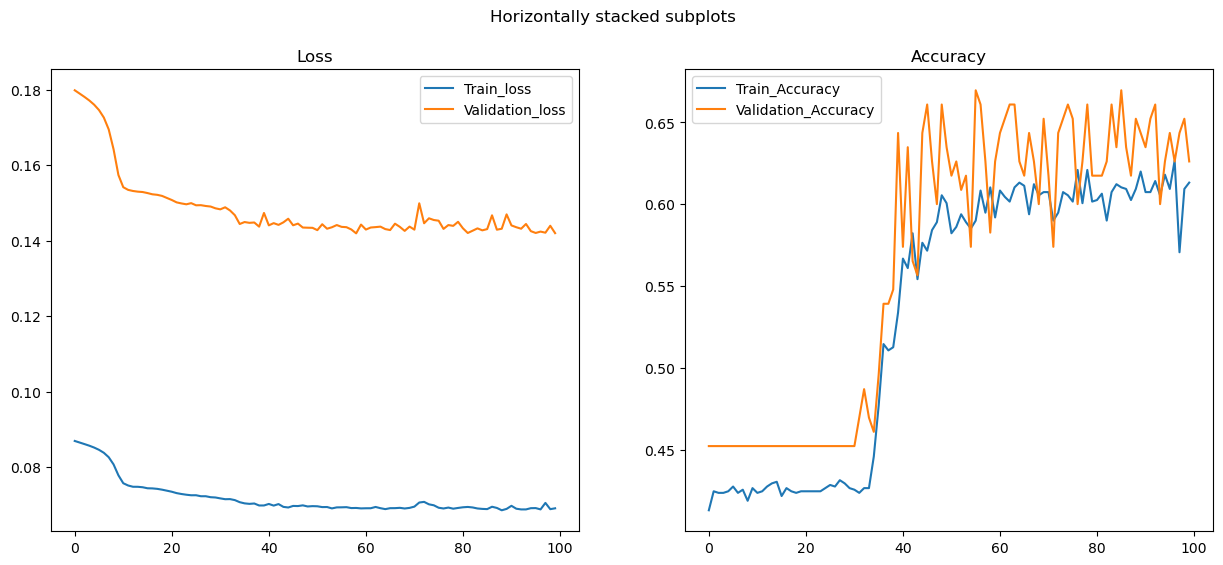

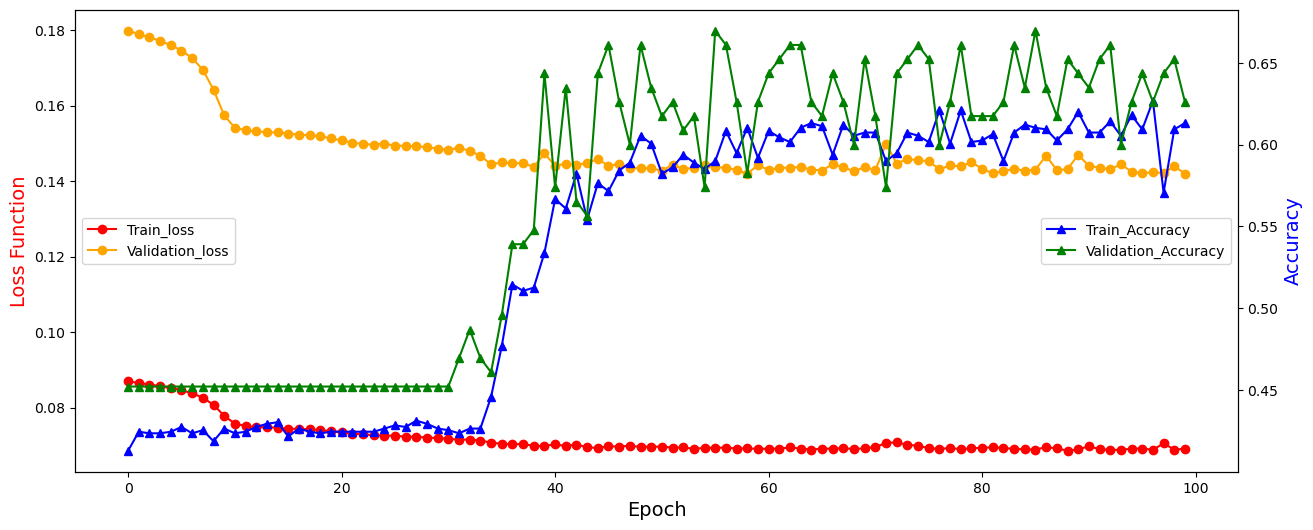

Current time: 31.480 minutes. Time expected till completion: 125.922 minutes

Epoch 101 of 500


100%|██████████| 15/15 [00:00<00:00, 17.41it/s]


train loss:  0.069016009799747
Val loss:  0.14329631380412888
train accuracy:  0.6063829787234043
Val accuracy:  0.6521739130434783
Current time: 31.772 minutes. Time expected till completion: 125.516 minutes

Epoch 102 of 500


100%|██████████| 15/15 [00:00<00:00, 17.31it/s]


train loss:  0.06885565952821211
Val loss:  0.14328793494597725
train accuracy:  0.6179883945841392
Val accuracy:  0.6521739130434783
Current time: 32.067 minutes. Time expected till completion: 125.126 minutes

Epoch 103 of 500


100%|██████████| 15/15 [00:00<00:00, 16.88it/s]


train loss:  0.06865688397529278
Val loss:  0.14343086532924487
train accuracy:  0.6083172147001934
Val accuracy:  0.6521739130434783
Current time: 32.363 minutes. Time expected till completion: 124.741 minutes

Epoch 104 of 500


100%|██████████| 15/15 [00:00<00:00, 17.17it/s]


train loss:  0.06887807612031756
Val loss:  0.1444249609242315
train accuracy:  0.6121856866537717
Val accuracy:  0.6521739130434783
Current time: 32.664 minutes. Time expected till completion: 124.374 minutes

Epoch 105 of 500


100%|██████████| 15/15 [00:00<00:00, 17.19it/s]


train loss:  0.06912560164351989
Val loss:  0.14256173735079558
train accuracy:  0.6112185686653772
Val accuracy:  0.6521739130434783
Current time: 32.960 minutes. Time expected till completion: 123.992 minutes

Epoch 106 of 500


100%|██████████| 15/15 [00:00<00:00, 17.51it/s]


train loss:  0.06890653699232946
Val loss:  0.14351488766462905
train accuracy:  0.6063829787234043
Val accuracy:  0.6173913043478261
Current time: 33.255 minutes. Time expected till completion: 123.610 minutes

Epoch 107 of 500


100%|██████████| 15/15 [00:00<00:00, 17.45it/s]


train loss:  0.06866785071112892
Val loss:  0.14293783281160438
train accuracy:  0.6141199226305609
Val accuracy:  0.6434782608695652
Current time: 33.550 minutes. Time expected till completion: 123.226 minutes

Epoch 108 of 500


100%|██████████| 15/15 [00:00<00:00, 17.51it/s]


train loss:  0.06897794750719052
Val loss:  0.14660542529562245
train accuracy:  0.6121856866537717
Val accuracy:  0.6086956521739131
Current time: 33.847 minutes. Time expected till completion: 122.854 minutes

Epoch 109 of 500


100%|██████████| 15/15 [00:00<00:00, 17.55it/s]


train loss:  0.06980332161517853
Val loss:  0.14643629219221033
train accuracy:  0.6025145067698259
Val accuracy:  0.6260869565217392
Current time: 34.143 minutes. Time expected till completion: 122.476 minutes

Epoch 110 of 500


100%|██████████| 15/15 [00:00<00:00, 17.53it/s]


train loss:  0.06896904047499312
Val loss:  0.14185976515645565
train accuracy:  0.6073500967117988
Val accuracy:  0.6434782608695652
Current time: 34.437 minutes. Time expected till completion: 122.097 minutes

Epoch 111 of 500


100%|██████████| 15/15 [00:00<00:00, 16.80it/s]


train loss:  0.0687595024214953
Val loss:  0.14566942090573518
train accuracy:  0.6063829787234043
Val accuracy:  0.6434782608695652
Current time: 34.734 minutes. Time expected till completion: 121.726 minutes

Epoch 112 of 500


100%|██████████| 15/15 [00:00<00:00, 16.94it/s]


train loss:  0.06924651133714377
Val loss:  0.14606855537580407
train accuracy:  0.6034816247582205
Val accuracy:  0.6434782608695652
Current time: 35.031 minutes. Time expected till completion: 121.358 minutes

Epoch 113 of 500


100%|██████████| 15/15 [00:00<00:00, 16.88it/s]


train loss:  0.06946545718255771
Val loss:  0.151064672159112
train accuracy:  0.6044487427466151
Val accuracy:  0.6260869565217392
Current time: 35.327 minutes. Time expected till completion: 120.988 minutes

Epoch 114 of 500


100%|██████████| 15/15 [00:00<00:00, 17.05it/s]


train loss:  0.07104465544108496
Val loss:  0.1447952757710996
train accuracy:  0.5831721470019342
Val accuracy:  0.6260869565217392
Current time: 35.623 minutes. Time expected till completion: 120.618 minutes

Epoch 115 of 500


100%|██████████| 15/15 [00:00<00:00, 17.53it/s]


train loss:  0.06972550043054429
Val loss:  0.14651743173599244
train accuracy:  0.6141199226305609
Val accuracy:  0.6434782608695652
Current time: 35.918 minutes. Time expected till completion: 120.247 minutes

Epoch 116 of 500


100%|██████████| 15/15 [00:00<00:00, 17.49it/s]


train loss:  0.06897908276238801
Val loss:  0.14478663154270338
train accuracy:  0.6160541586073501
Val accuracy:  0.6608695652173913
Current time: 36.215 minutes. Time expected till completion: 119.884 minutes

Epoch 117 of 500


100%|██████████| 15/15 [00:00<00:00, 17.47it/s]


train loss:  0.06866504496947018
Val loss:  0.14480143629986306
train accuracy:  0.6054158607350096
Val accuracy:  0.6608695652173913
Current time: 36.511 minutes. Time expected till completion: 119.518 minutes

Epoch 118 of 500


100%|██████████| 15/15 [00:00<00:00, 17.33it/s]


train loss:  0.06918994318585793
Val loss:  0.1428551046744637
train accuracy:  0.6112185686653772
Val accuracy:  0.6521739130434783
Current time: 36.808 minutes. Time expected till completion: 119.159 minutes

Epoch 119 of 500


100%|██████████| 15/15 [00:00<00:00, 17.65it/s]


train loss:  0.0689090267256104
Val loss:  0.1452834181163622
train accuracy:  0.6160541586073501
Val accuracy:  0.6608695652173913
Current time: 37.103 minutes. Time expected till completion: 118.793 minutes

Epoch 120 of 500


100%|██████████| 15/15 [00:00<00:00, 17.27it/s]


train loss:  0.068922909189239
Val loss:  0.14319922820381495
train accuracy:  0.6179883945841392
Val accuracy:  0.6434782608695652
Current time: 37.399 minutes. Time expected till completion: 118.431 minutes

Epoch 121 of 500


100%|██████████| 15/15 [00:00<00:00, 17.19it/s]


train loss:  0.06860719814291313
Val loss:  0.14328246116638182
train accuracy:  0.6092843326885881
Val accuracy:  0.6521739130434783
Current time: 37.699 minutes. Time expected till completion: 118.081 minutes

Epoch 122 of 500


100%|██████████| 15/15 [00:00<00:00, 17.33it/s]


train loss:  0.06909323199805255
Val loss:  0.14603071109108304
train accuracy:  0.6121856866537717
Val accuracy:  0.6521739130434783
Current time: 37.995 minutes. Time expected till completion: 117.721 minutes

Epoch 123 of 500


100%|██████████| 15/15 [00:00<00:00, 17.51it/s]


train loss:  0.06944796356518448
Val loss:  0.1441121422726175
train accuracy:  0.6005802707930368
Val accuracy:  0.6608695652173913
Current time: 38.289 minutes. Time expected till completion: 117.358 minutes

Epoch 124 of 500


100%|██████████| 15/15 [00:00<00:00, 17.57it/s]


train loss:  0.069184712330654
Val loss:  0.143746905223183
train accuracy:  0.6102514506769826
Val accuracy:  0.6608695652173913
Current time: 38.584 minutes. Time expected till completion: 116.998 minutes

Epoch 125 of 500


100%|██████████| 15/15 [00:00<00:00, 17.47it/s]


train loss:  0.06871011962743054
Val loss:  0.14249145362688148
train accuracy:  0.6179883945841392
Val accuracy:  0.6695652173913044
Current time: 38.881 minutes. Time expected till completion: 116.643 minutes

Epoch 126 of 500


100%|██████████| 15/15 [00:00<00:00, 17.45it/s]


train loss:  0.06880183434348042
Val loss:  0.14489410441854725
train accuracy:  0.6141199226305609
Val accuracy:  0.6434782608695652
Current time: 39.176 minutes. Time expected till completion: 116.285 minutes

Epoch 127 of 500


100%|██████████| 15/15 [00:00<00:00, 17.41it/s]


train loss:  0.06890341893155524
Val loss:  0.1438424208889837
train accuracy:  0.6025145067698259
Val accuracy:  0.6434782608695652
Current time: 39.470 minutes. Time expected till completion: 115.924 minutes

Epoch 128 of 500


100%|██████████| 15/15 [00:00<00:00, 17.23it/s]


train loss:  0.0686785943618826
Val loss:  0.145913929524629
train accuracy:  0.6160541586073501
Val accuracy:  0.6347826086956522
Current time: 39.764 minutes. Time expected till completion: 115.565 minutes

Epoch 129 of 500


100%|██████████| 15/15 [00:00<00:00, 17.43it/s]


train loss:  0.06872022428641697
Val loss:  0.14371873036674832
train accuracy:  0.6189555125725339
Val accuracy:  0.6521739130434783
Current time: 40.061 minutes. Time expected till completion: 115.213 minutes

Epoch 130 of 500


100%|██████████| 15/15 [00:00<00:00, 17.03it/s]


train loss:  0.06871243481248675
Val loss:  0.1447768843692282
train accuracy:  0.6054158607350096
Val accuracy:  0.6608695652173913
Current time: 40.356 minutes. Time expected till completion: 114.859 minutes

Epoch 131 of 500


100%|██████████| 15/15 [00:00<00:00, 16.94it/s]


train loss:  0.06852418783785527
Val loss:  0.14409974450650423
train accuracy:  0.6170212765957447
Val accuracy:  0.6173913043478261
Current time: 40.652 minutes. Time expected till completion: 114.509 minutes

Epoch 132 of 500


100%|██████████| 15/15 [00:00<00:00, 17.49it/s]


train loss:  0.06889668504781372
Val loss:  0.14362868588903677
train accuracy:  0.6160541586073501
Val accuracy:  0.6347826086956522
Current time: 40.948 minutes. Time expected till completion: 114.157 minutes

Epoch 133 of 500


100%|██████████| 15/15 [00:00<00:00, 17.29it/s]


train loss:  0.06870775930655533
Val loss:  0.14333834388981695
train accuracy:  0.6199226305609284
Val accuracy:  0.6434782608695652
Current time: 41.243 minutes. Time expected till completion: 113.807 minutes

Epoch 134 of 500


100%|██████████| 15/15 [00:00<00:00, 17.49it/s]


train loss:  0.06896292056520857
Val loss:  0.1445116955301036
train accuracy:  0.6083172147001934
Val accuracy:  0.6347826086956522
Current time: 41.538 minutes. Time expected till completion: 113.454 minutes

Epoch 135 of 500


100%|██████████| 15/15 [00:00<00:00, 17.25it/s]


train loss:  0.06878238599351112
Val loss:  0.14385459941366444
train accuracy:  0.6189555125725339
Val accuracy:  0.6521739130434783
Current time: 41.834 minutes. Time expected till completion: 113.106 minutes

Epoch 136 of 500


100%|██████████| 15/15 [00:00<00:00, 17.61it/s]


train loss:  0.0689311160109721
Val loss:  0.14259999368501747
train accuracy:  0.6179883945841392
Val accuracy:  0.6434782608695652
Current time: 42.128 minutes. Time expected till completion: 112.755 minutes

Epoch 137 of 500


100%|██████████| 15/15 [00:00<00:00, 17.33it/s]


train loss:  0.06852571190671718
Val loss:  0.1443397765574248
train accuracy:  0.6199226305609284
Val accuracy:  0.6347826086956522
Current time: 42.424 minutes. Time expected till completion: 112.407 minutes

Epoch 138 of 500


100%|██████████| 15/15 [00:00<00:00, 17.35it/s]


train loss:  0.06881785882741386
Val loss:  0.14300228046334307
train accuracy:  0.6179883945841392
Val accuracy:  0.6521739130434783
Current time: 42.721 minutes. Time expected till completion: 112.064 minutes

Epoch 139 of 500


100%|██████████| 15/15 [00:00<00:00, 17.03it/s]


train loss:  0.06859057017636253
Val loss:  0.14510044688763826
train accuracy:  0.6102514506769826
Val accuracy:  0.6521739130434783
Current time: 43.017 minutes. Time expected till completion: 111.719 minutes

Epoch 140 of 500


100%|██████████| 15/15 [00:00<00:00, 17.13it/s]


train loss:  0.06872905828274888
Val loss:  0.14385220278864322
train accuracy:  0.6131528046421664
Val accuracy:  0.6434782608695652
Current time: 43.312 minutes. Time expected till completion: 111.374 minutes

Epoch 141 of 500


100%|██████████| 15/15 [00:00<00:00, 17.45it/s]


train loss:  0.06850739875430065
Val loss:  0.14279883218848188
train accuracy:  0.6121856866537717
Val accuracy:  0.6521739130434783
Current time: 43.607 minutes. Time expected till completion: 111.027 minutes

Epoch 142 of 500


100%|██████████| 15/15 [00:00<00:00, 17.57it/s]


train loss:  0.06879571051385462
Val loss:  0.143654625830443
train accuracy:  0.6102514506769826
Val accuracy:  0.6173913043478261
Current time: 43.902 minutes. Time expected till completion: 110.684 minutes

Epoch 143 of 500


100%|██████████| 15/15 [00:00<00:00, 17.37it/s]


train loss:  0.06908161889192445
Val loss:  0.14607739604037742
train accuracy:  0.6112185686653772
Val accuracy:  0.6434782608695652
Current time: 44.198 minutes. Time expected till completion: 110.340 minutes

Epoch 144 of 500


100%|██████████| 15/15 [00:00<00:00, 17.53it/s]


train loss:  0.06921633766744308
Val loss:  0.14354885142782461
train accuracy:  0.6131528046421664
Val accuracy:  0.6521739130434783
Current time: 44.493 minutes. Time expected till completion: 109.996 minutes

Epoch 145 of 500


100%|██████████| 15/15 [00:00<00:00, 17.25it/s]


train loss:  0.06872607793522066
Val loss:  0.14235774952432384
train accuracy:  0.6179883945841392
Val accuracy:  0.6608695652173913
Current time: 44.789 minutes. Time expected till completion: 109.655 minutes

Epoch 146 of 500


100%|██████████| 15/15 [00:00<00:00, 17.45it/s]


train loss:  0.06897301000598782
Val loss:  0.14368021488189697
train accuracy:  0.6141199226305609
Val accuracy:  0.6347826086956522
Current time: 45.084 minutes. Time expected till completion: 109.314 minutes

Epoch 147 of 500


100%|██████████| 15/15 [00:00<00:00, 17.41it/s]


train loss:  0.06873654506423256
Val loss:  0.1423608344534169
train accuracy:  0.6179883945841392
Val accuracy:  0.6608695652173913
Current time: 45.380 minutes. Time expected till completion: 108.973 minutes

Epoch 148 of 500


100%|██████████| 15/15 [00:00<00:00, 16.96it/s]


train loss:  0.06858836030821736
Val loss:  0.14335595317508865
train accuracy:  0.6189555125725339
Val accuracy:  0.6608695652173913
Current time: 45.676 minutes. Time expected till completion: 108.634 minutes

Epoch 149 of 500


100%|██████████| 15/15 [00:00<00:00, 16.98it/s]


train loss:  0.06887689866918198
Val loss:  0.1430868853693423
train accuracy:  0.6228239845261122
Val accuracy:  0.6695652173913044
Current time: 45.972 minutes. Time expected till completion: 108.296 minutes

Epoch 150 of 500


100%|██████████| 15/15 [00:00<00:00, 17.29it/s]


train loss:  0.0685688528724058
Val loss:  0.14303175988404648
train accuracy:  0.6199226305609284
Val accuracy:  0.6608695652173913
Current time: 46.267 minutes. Time expected till completion: 107.956 minutes

Epoch 151 of 500


100%|██████████| 15/15 [00:00<00:00, 17.59it/s]


train loss:  0.06870696248353335
Val loss:  0.14352450007977693
train accuracy:  0.6170212765957447
Val accuracy:  0.6521739130434783
Current time: 46.562 minutes. Time expected till completion: 107.616 minutes

Epoch 152 of 500


100%|██████████| 15/15 [00:00<00:00, 16.98it/s]


train loss:  0.06838864531922847
Val loss:  0.14299849116283914
train accuracy:  0.6131528046421664
Val accuracy:  0.6521739130434783
Current time: 46.863 minutes. Time expected till completion: 107.292 minutes

Epoch 153 of 500


100%|██████████| 15/15 [00:00<00:00, 17.17it/s]


train loss:  0.06840660626238043
Val loss:  0.14510255378225576
train accuracy:  0.6189555125725339
Val accuracy:  0.6434782608695652
Current time: 47.163 minutes. Time expected till completion: 106.964 minutes

Epoch 154 of 500


100%|██████████| 15/15 [00:00<00:00, 17.07it/s]


train loss:  0.06857472029829856
Val loss:  0.1467094317726467
train accuracy:  0.6092843326885881
Val accuracy:  0.6173913043478261
Current time: 47.464 minutes. Time expected till completion: 106.640 minutes

Epoch 155 of 500


100%|██████████| 15/15 [00:00<00:00, 17.57it/s]


train loss:  0.06934170831333507
Val loss:  0.143649204917576
train accuracy:  0.6073500967117988
Val accuracy:  0.6260869565217392
Current time: 47.760 minutes. Time expected till completion: 106.305 minutes

Epoch 156 of 500


100%|██████████| 15/15 [00:00<00:00, 17.61it/s]


train loss:  0.06870733031451817
Val loss:  0.14218335151672362
train accuracy:  0.620889748549323
Val accuracy:  0.6608695652173913
Current time: 48.055 minutes. Time expected till completion: 105.967 minutes

Epoch 157 of 500


100%|██████████| 15/15 [00:00<00:00, 17.15it/s]


train loss:  0.0686705887202368
Val loss:  0.14312861535860144
train accuracy:  0.6237911025145068
Val accuracy:  0.6521739130434783
Current time: 48.350 minutes. Time expected till completion: 105.631 minutes

Epoch 158 of 500


100%|██████████| 15/15 [00:00<00:00, 16.94it/s]


train loss:  0.06880006413164637
Val loss:  0.14414547474487968
train accuracy:  0.6199226305609284
Val accuracy:  0.6347826086956522
Current time: 48.645 minutes. Time expected till completion: 105.294 minutes

Epoch 159 of 500


100%|██████████| 15/15 [00:00<00:00, 17.78it/s]


train loss:  0.06902037609937804
Val loss:  0.14350609105566273
train accuracy:  0.6131528046421664
Val accuracy:  0.6521739130434783
Current time: 48.941 minutes. Time expected till completion: 104.962 minutes

Epoch 160 of 500


100%|██████████| 15/15 [00:00<00:00, 17.49it/s]


train loss:  0.0688288758870942
Val loss:  0.14167596879212752
train accuracy:  0.6092843326885881
Val accuracy:  0.6347826086956522
Current time: 49.237 minutes. Time expected till completion: 104.628 minutes

Epoch 161 of 500


100%|██████████| 15/15 [00:00<00:00, 17.41it/s]


train loss:  0.06856471478823767
Val loss:  0.1432938119639521
train accuracy:  0.6102514506769826
Val accuracy:  0.6521739130434783
Current time: 49.538 minutes. Time expected till completion: 104.307 minutes

Epoch 162 of 500


100%|██████████| 15/15 [00:00<00:00, 17.43it/s]


train loss:  0.06855976777565548
Val loss:  0.14298835733662482
train accuracy:  0.6218568665377177
Val accuracy:  0.6521739130434783
Current time: 49.833 minutes. Time expected till completion: 103.972 minutes

Epoch 163 of 500


100%|██████████| 15/15 [00:00<00:00, 17.72it/s]


train loss:  0.0685999226869882
Val loss:  0.1449329796044723
train accuracy:  0.6150870406189555
Val accuracy:  0.6434782608695652
Current time: 50.126 minutes. Time expected till completion: 103.635 minutes

Epoch 164 of 500


100%|██████████| 15/15 [00:00<00:00, 17.37it/s]


train loss:  0.06873507293326711
Val loss:  0.1422391818917316
train accuracy:  0.6179883945841392
Val accuracy:  0.6434782608695652
Current time: 50.422 minutes. Time expected till completion: 103.303 minutes

Epoch 165 of 500


100%|██████████| 15/15 [00:00<00:00, 17.65it/s]


train loss:  0.06896237224859242
Val loss:  0.14196171138597571
train accuracy:  0.6150870406189555
Val accuracy:  0.6434782608695652
Current time: 50.718 minutes. Time expected till completion: 102.973 minutes

Epoch 166 of 500


100%|██████████| 15/15 [00:00<00:00, 17.09it/s]


train loss:  0.06825074651485716
Val loss:  0.14428112506866456
train accuracy:  0.6179883945841392
Val accuracy:  0.6434782608695652
Current time: 51.015 minutes. Time expected till completion: 102.644 minutes

Epoch 167 of 500


100%|██████████| 15/15 [00:00<00:00, 17.03it/s]


train loss:  0.06887247305312978
Val loss:  0.14313728964847067
train accuracy:  0.6160541586073501
Val accuracy:  0.6347826086956522
Current time: 51.312 minutes. Time expected till completion: 102.316 minutes

Epoch 168 of 500


100%|██████████| 15/15 [00:00<00:00, 17.29it/s]


train loss:  0.06904892995233
Val loss:  0.14541836562363997
train accuracy:  0.6189555125725339
Val accuracy:  0.6434782608695652
Current time: 51.606 minutes. Time expected till completion: 101.984 minutes

Epoch 169 of 500


100%|██████████| 15/15 [00:00<00:00, 17.33it/s]


train loss:  0.06936318397060814
Val loss:  0.14495134871938956
train accuracy:  0.6189555125725339
Val accuracy:  0.6608695652173913
Current time: 51.904 minutes. Time expected till completion: 101.659 minutes

Epoch 170 of 500


100%|██████████| 15/15 [00:00<00:00, 17.47it/s]


train loss:  0.0694475996540409
Val loss:  0.14636386062787926
train accuracy:  0.6063829787234043
Val accuracy:  0.6434782608695652
Current time: 52.197 minutes. Time expected till completion: 101.324 minutes

Epoch 171 of 500


100%|██████████| 15/15 [00:00<00:00, 17.53it/s]


train loss:  0.06901040644433558
Val loss:  0.14487897105838943
train accuracy:  0.6199226305609284
Val accuracy:  0.6521739130434783
Current time: 52.489 minutes. Time expected till completion: 100.987 minutes

Epoch 172 of 500


100%|██████████| 15/15 [00:00<00:00, 17.41it/s]


train loss:  0.0686453546845936
Val loss:  0.14384571780329164
train accuracy:  0.6237911025145068
Val accuracy:  0.6434782608695652
Current time: 52.783 minutes. Time expected till completion: 100.656 minutes

Epoch 173 of 500


100%|██████████| 15/15 [00:00<00:00, 17.55it/s]


train loss:  0.06890839390182864
Val loss:  0.1428751722626064
train accuracy:  0.6073500967117988
Val accuracy:  0.6434782608695652
Current time: 53.077 minutes. Time expected till completion: 100.325 minutes

Epoch 174 of 500


100%|██████████| 15/15 [00:00<00:00, 17.19it/s]


train loss:  0.06887665563902495
Val loss:  0.14269642415254014
train accuracy:  0.6160541586073501
Val accuracy:  0.6434782608695652
Current time: 53.372 minutes. Time expected till completion: 99.996 minutes

Epoch 175 of 500


100%|██████████| 15/15 [00:00<00:00, 17.35it/s]


train loss:  0.06863933265555067
Val loss:  0.14332646857137266
train accuracy:  0.6218568665377177
Val accuracy:  0.6521739130434783
Current time: 53.666 minutes. Time expected till completion: 99.665 minutes

Epoch 176 of 500


100%|██████████| 15/15 [00:00<00:00, 17.05it/s]


train loss:  0.0687481060018853
Val loss:  0.14273122704547384
train accuracy:  0.6189555125725339
Val accuracy:  0.6521739130434783
Current time: 53.961 minutes. Time expected till completion: 99.338 minutes

Epoch 177 of 500


100%|██████████| 15/15 [00:00<00:00, 16.92it/s]


train loss:  0.06850244661133802
Val loss:  0.1434320988862411
train accuracy:  0.6170212765957447
Val accuracy:  0.6521739130434783
Current time: 54.258 minutes. Time expected till completion: 99.014 minutes

Epoch 178 of 500


100%|██████████| 15/15 [00:00<00:00, 17.33it/s]


train loss:  0.06840164581857751
Val loss:  0.1435385735138603
train accuracy:  0.6170212765957447
Val accuracy:  0.6521739130434783
Current time: 54.557 minutes. Time expected till completion: 98.693 minutes

Epoch 179 of 500


100%|██████████| 15/15 [00:00<00:00, 17.49it/s]


train loss:  0.06858094904132231
Val loss:  0.1431232063666634
train accuracy:  0.6179883945841392
Val accuracy:  0.6521739130434783
Current time: 54.854 minutes. Time expected till completion: 98.370 minutes

Epoch 180 of 500


100%|██████████| 15/15 [00:00<00:00, 17.57it/s]


train loss:  0.06873334630084453
Val loss:  0.14204566841540128
train accuracy:  0.6150870406189555
Val accuracy:  0.6521739130434783
Current time: 55.153 minutes. Time expected till completion: 98.049 minutes

Epoch 181 of 500


100%|██████████| 15/15 [00:00<00:00, 17.57it/s]


train loss:  0.06875293472749353
Val loss:  0.14215353779170825
train accuracy:  0.6131528046421664
Val accuracy:  0.6521739130434783
Current time: 55.447 minutes. Time expected till completion: 97.721 minutes

Epoch 182 of 500


100%|██████████| 15/15 [00:00<00:00, 17.31it/s]


train loss:  0.06888799671969977
Val loss:  0.14277718585470447
train accuracy:  0.6044487427466151
Val accuracy:  0.6521739130434783
Current time: 55.742 minutes. Time expected till completion: 97.395 minutes

Epoch 183 of 500


100%|██████████| 15/15 [00:00<00:00, 17.53it/s]


train loss:  0.06903875635025349
Val loss:  0.14374350050221318
train accuracy:  0.6199226305609284
Val accuracy:  0.6521739130434783
Current time: 56.038 minutes. Time expected till completion: 97.072 minutes

Epoch 184 of 500


100%|██████████| 15/15 [00:00<00:00, 17.09it/s]


train loss:  0.06873108916402555
Val loss:  0.14372922233913255
train accuracy:  0.6189555125725339
Val accuracy:  0.6521739130434783
Current time: 56.332 minutes. Time expected till completion: 96.743 minutes

Epoch 185 of 500


100%|██████████| 15/15 [00:00<00:00, 17.11it/s]


train loss:  0.0689754940900858
Val loss:  0.14500407136004903
train accuracy:  0.6073500967117988
Val accuracy:  0.6347826086956522
Current time: 56.626 minutes. Time expected till completion: 96.418 minutes

Epoch 186 of 500


100%|██████████| 15/15 [00:00<00:00, 17.19it/s]


train loss:  0.06915267708223147
Val loss:  0.1435836812724238
train accuracy:  0.6112185686653772
Val accuracy:  0.6521739130434783
Current time: 56.920 minutes. Time expected till completion: 96.091 minutes

Epoch 187 of 500


100%|██████████| 15/15 [00:00<00:00, 17.49it/s]


train loss:  0.06885170089207028
Val loss:  0.14319563948589822
train accuracy:  0.6237911025145068
Val accuracy:  0.6434782608695652
Current time: 57.214 minutes. Time expected till completion: 95.765 minutes

Epoch 188 of 500


100%|██████████| 15/15 [00:00<00:00, 16.94it/s]


train loss:  0.06868805876091785
Val loss:  0.14444553489270417
train accuracy:  0.6170212765957447
Val accuracy:  0.6434782608695652
Current time: 57.512 minutes. Time expected till completion: 95.446 minutes

Epoch 189 of 500


100%|██████████| 15/15 [00:00<00:00, 17.65it/s]


train loss:  0.06900598198117786
Val loss:  0.143449344324029
train accuracy:  0.6025145067698259
Val accuracy:  0.6521739130434783
Current time: 57.807 minutes. Time expected till completion: 95.121 minutes

Epoch 190 of 500


100%|██████████| 15/15 [00:00<00:00, 17.49it/s]


train loss:  0.06893006197719094
Val loss:  0.14400126623070758
train accuracy:  0.6092843326885881
Val accuracy:  0.6434782608695652
Current time: 58.101 minutes. Time expected till completion: 94.797 minutes

Epoch 191 of 500


100%|██████████| 15/15 [00:00<00:00, 17.53it/s]


train loss:  0.06907676947186026
Val loss:  0.14562840358070706
train accuracy:  0.6160541586073501
Val accuracy:  0.6347826086956522
Current time: 58.394 minutes. Time expected till completion: 94.470 minutes

Epoch 192 of 500


100%|██████████| 15/15 [00:00<00:00, 17.41it/s]


train loss:  0.06894184219537436
Val loss:  0.14514363071192865
train accuracy:  0.6237911025145068
Val accuracy:  0.6347826086956522
Current time: 58.687 minutes. Time expected till completion: 94.144 minutes

Epoch 193 of 500


100%|██████████| 15/15 [00:00<00:00, 17.41it/s]


train loss:  0.06862509798265748
Val loss:  0.14391494937565016
train accuracy:  0.6179883945841392
Val accuracy:  0.6521739130434783
Current time: 58.981 minutes. Time expected till completion: 93.820 minutes

Epoch 194 of 500


100%|██████████| 15/15 [00:00<00:00, 17.05it/s]


train loss:  0.06886227622022942
Val loss:  0.14286960674368818
train accuracy:  0.6112185686653772
Val accuracy:  0.6347826086956522
Current time: 59.274 minutes. Time expected till completion: 93.495 minutes

Epoch 195 of 500


100%|██████████| 15/15 [00:00<00:00, 17.01it/s]


train loss:  0.06849869480446644
Val loss:  0.1441024801005488
train accuracy:  0.6179883945841392
Val accuracy:  0.6347826086956522
Current time: 59.569 minutes. Time expected till completion: 93.172 minutes

Epoch 196 of 500


100%|██████████| 15/15 [00:00<00:00, 17.07it/s]


train loss:  0.06846839679509574
Val loss:  0.14396973848342895
train accuracy:  0.6189555125725339
Val accuracy:  0.6434782608695652
Current time: 59.863 minutes. Time expected till completion: 92.849 minutes

Epoch 197 of 500


100%|██████████| 15/15 [00:00<00:00, 17.61it/s]


train loss:  0.06879318440675275
Val loss:  0.1440677321475485
train accuracy:  0.6121856866537717
Val accuracy:  0.6434782608695652
Current time: 60.155 minutes. Time expected till completion: 92.523 minutes

Epoch 198 of 500


100%|██████████| 15/15 [00:00<00:00, 17.65it/s]


train loss:  0.06860253168720341
Val loss:  0.14360514153604922
train accuracy:  0.6179883945841392
Val accuracy:  0.6521739130434783
Current time: 60.449 minutes. Time expected till completion: 92.200 minutes

Epoch 199 of 500


100%|██████████| 15/15 [00:00<00:00, 16.92it/s]


train loss:  0.06896118718835326
Val loss:  0.14362093987672225
train accuracy:  0.6112185686653772
Val accuracy:  0.6434782608695652
Current time: 60.741 minutes. Time expected till completion: 91.875 minutes

Epoch 200 of 500


100%|██████████| 15/15 [00:00<00:00, 17.41it/s]


train loss:  0.0687279710456066
Val loss:  0.14338603019714355
train accuracy:  0.6160541586073501
Val accuracy:  0.6173913043478261
Saving model checkpoint


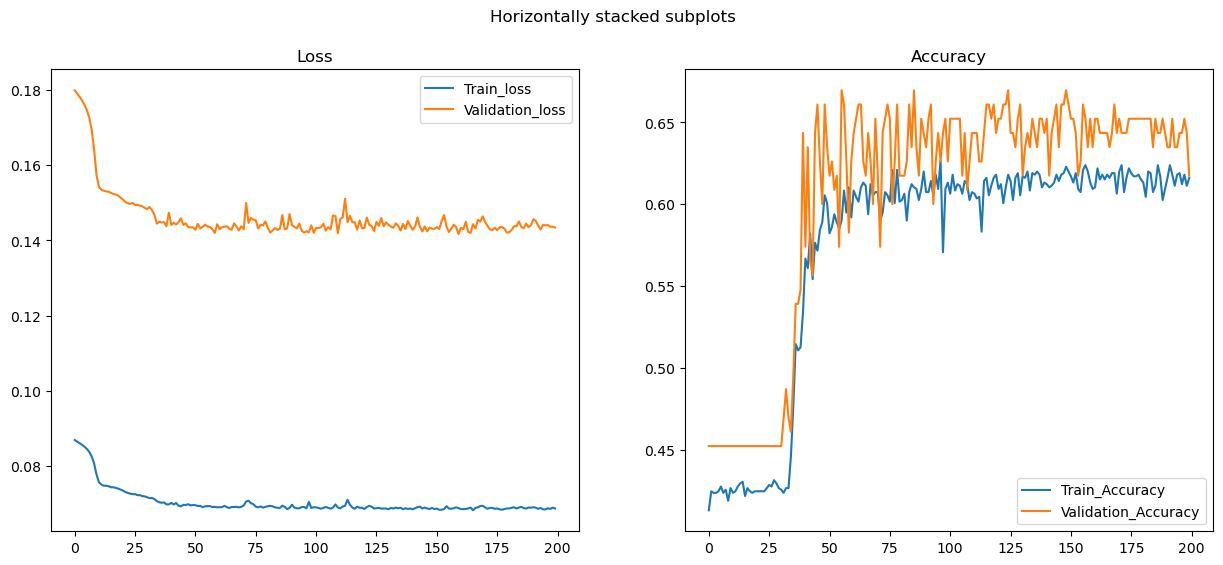

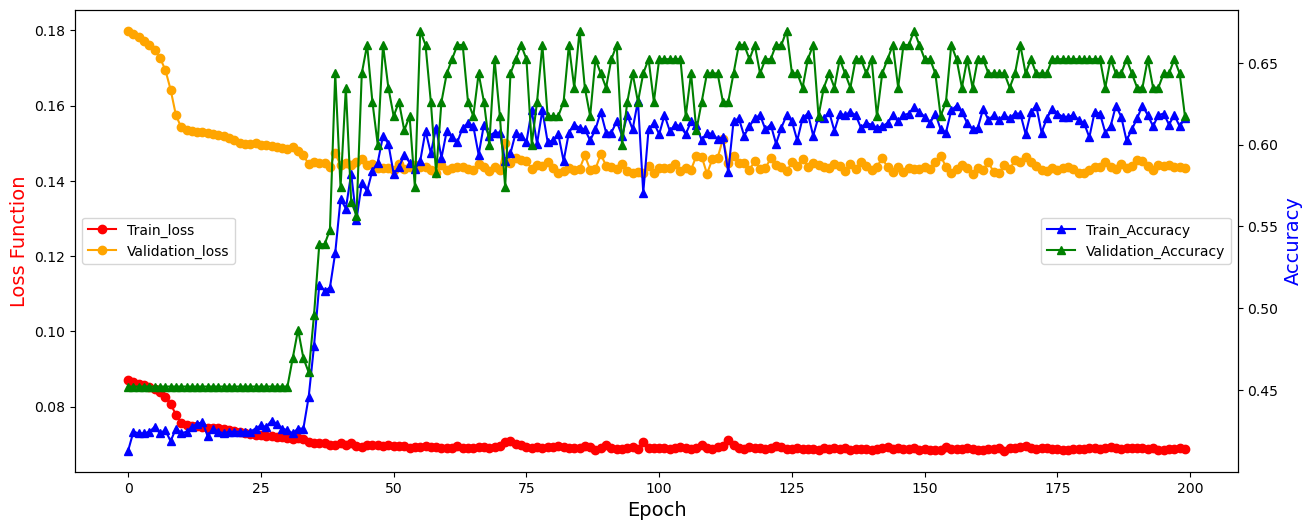

Current time: 61.049 minutes. Time expected till completion: 91.574 minutes

Epoch 201 of 500


100%|██████████| 15/15 [00:00<00:00, 17.45it/s]


train loss:  0.0685480164951236
Val loss:  0.14403744262197743
train accuracy:  0.6150870406189555
Val accuracy:  0.6434782608695652
Current time: 61.341 minutes. Time expected till completion: 91.249 minutes

Epoch 202 of 500


100%|██████████| 15/15 [00:00<00:00, 17.39it/s]


train loss:  0.06881078985489084
Val loss:  0.14323508739471436
train accuracy:  0.6170212765957447
Val accuracy:  0.6434782608695652
Current time: 61.633 minutes. Time expected till completion: 90.923 minutes

Epoch 203 of 500


100%|██████████| 15/15 [00:00<00:00, 17.33it/s]


train loss:  0.06850285041263071
Val loss:  0.14278223099915877
train accuracy:  0.6189555125725339
Val accuracy:  0.6521739130434783
Current time: 61.925 minutes. Time expected till completion: 90.599 minutes

Epoch 204 of 500


100%|██████████| 15/15 [00:00<00:00, 17.13it/s]


train loss:  0.0684529975834852
Val loss:  0.1428218318068463
train accuracy:  0.620889748549323
Val accuracy:  0.6521739130434783
Current time: 62.217 minutes. Time expected till completion: 90.275 minutes

Epoch 205 of 500


100%|██████████| 15/15 [00:00<00:00, 16.90it/s]


train loss:  0.06842200230353114
Val loss:  0.14282452541848886
train accuracy:  0.6228239845261122
Val accuracy:  0.6260869565217392
Current time: 62.511 minutes. Time expected till completion: 89.955 minutes

Epoch 206 of 500


100%|██████████| 15/15 [00:00<00:00, 17.39it/s]


train loss:  0.06852655674779438
Val loss:  0.1435448003851849
train accuracy:  0.6179883945841392
Val accuracy:  0.6521739130434783
Current time: 62.806 minutes. Time expected till completion: 89.635 minutes

Epoch 207 of 500


100%|██████████| 15/15 [00:00<00:00, 17.43it/s]


train loss:  0.06840057005273535
Val loss:  0.14357352256774902
train accuracy:  0.6199226305609284
Val accuracy:  0.6521739130434783
Current time: 63.097 minutes. Time expected till completion: 89.312 minutes

Epoch 208 of 500


100%|██████████| 15/15 [00:00<00:00, 17.45it/s]


train loss:  0.06881180820658774
Val loss:  0.14291150984556777
train accuracy:  0.6131528046421664
Val accuracy:  0.6260869565217392
Current time: 63.393 minutes. Time expected till completion: 88.994 minutes

Epoch 209 of 500


100%|██████████| 15/15 [00:00<00:00, 17.45it/s]


train loss:  0.06865855451939876
Val loss:  0.14351380804310673
train accuracy:  0.6199226305609284
Val accuracy:  0.6521739130434783
Current time: 63.685 minutes. Time expected till completion: 88.672 minutes

Epoch 210 of 500


100%|██████████| 15/15 [00:00<00:00, 17.33it/s]


train loss:  0.06870934078956249
Val loss:  0.1432183042816494
train accuracy:  0.6092843326885881
Val accuracy:  0.6608695652173913
Current time: 63.979 minutes. Time expected till completion: 88.351 minutes

Epoch 211 of 500


100%|██████████| 15/15 [00:00<00:00, 17.27it/s]


train loss:  0.06853041992427301
Val loss:  0.1438311348790708
train accuracy:  0.6170212765957447
Val accuracy:  0.6608695652173913
Current time: 64.271 minutes. Time expected till completion: 88.030 minutes

Epoch 212 of 500


100%|██████████| 15/15 [00:00<00:00, 17.37it/s]


train loss:  0.06870755950994141
Val loss:  0.14257567447164785
train accuracy:  0.6102514506769826
Val accuracy:  0.6608695652173913
Current time: 64.562 minutes. Time expected till completion: 87.707 minutes

Epoch 213 of 500


100%|██████████| 15/15 [00:00<00:00, 17.41it/s]


train loss:  0.06884699812018433
Val loss:  0.14322018416031548
train accuracy:  0.6189555125725339
Val accuracy:  0.6521739130434783
Current time: 64.855 minutes. Time expected till completion: 87.387 minutes

Epoch 214 of 500


100%|██████████| 15/15 [00:00<00:00, 16.69it/s]


train loss:  0.06926883829170316
Val loss:  0.14418734415717746
train accuracy:  0.6005802707930368
Val accuracy:  0.6347826086956522
Current time: 65.148 minutes. Time expected till completion: 87.067 minutes

Epoch 215 of 500


100%|██████████| 15/15 [00:00<00:00, 16.96it/s]


train loss:  0.06847545758206794
Val loss:  0.14285060374633127
train accuracy:  0.6266924564796905
Val accuracy:  0.6521739130434783
Current time: 65.443 minutes. Time expected till completion: 86.749 minutes

Epoch 216 of 500


100%|██████████| 15/15 [00:00<00:00, 17.01it/s]


train loss:  0.06869369935482106
Val loss:  0.14301578739415044
train accuracy:  0.6170212765957447
Val accuracy:  0.6608695652173913
Current time: 65.738 minutes. Time expected till completion: 86.433 minutes

Epoch 217 of 500


100%|██████████| 15/15 [00:00<00:00, 17.37it/s]


train loss:  0.06870788681668516
Val loss:  0.1428547335707623
train accuracy:  0.6150870406189555
Val accuracy:  0.6521739130434783
Current time: 66.032 minutes. Time expected till completion: 86.115 minutes

Epoch 218 of 500


100%|██████████| 15/15 [00:00<00:00, 17.57it/s]


train loss:  0.06846284693398835
Val loss:  0.1434739086938941
train accuracy:  0.6160541586073501
Val accuracy:  0.6521739130434783
Current time: 66.327 minutes. Time expected till completion: 85.799 minutes

Epoch 219 of 500


100%|██████████| 15/15 [00:00<00:00, 17.45it/s]


train loss:  0.0686986543800199
Val loss:  0.14304249960443247
train accuracy:  0.6247582205029013
Val accuracy:  0.6521739130434783
Current time: 66.620 minutes. Time expected till completion: 85.481 minutes

Epoch 220 of 500


100%|██████████| 15/15 [00:00<00:00, 17.39it/s]


train loss:  0.06875688114295384
Val loss:  0.14362538793812626
train accuracy:  0.6199226305609284
Val accuracy:  0.6521739130434783
Current time: 66.916 minutes. Time expected till completion: 85.166 minutes

Epoch 221 of 500


100%|██████████| 15/15 [00:00<00:00, 17.47it/s]


train loss:  0.06829408030214808
Val loss:  0.14285235508628513
train accuracy:  0.6237911025145068
Val accuracy:  0.6608695652173913
Current time: 67.211 minutes. Time expected till completion: 84.850 minutes

Epoch 222 of 500


100%|██████████| 15/15 [00:00<00:00, 17.01it/s]


train loss:  0.06842883942897361
Val loss:  0.14304779094198475
train accuracy:  0.6276595744680851
Val accuracy:  0.6608695652173913
Current time: 67.505 minutes. Time expected till completion: 84.534 minutes

Epoch 223 of 500


100%|██████████| 15/15 [00:00<00:00, 17.09it/s]


train loss:  0.06845106740754163
Val loss:  0.14347094556559686
train accuracy:  0.6218568665377177
Val accuracy:  0.6608695652173913
Current time: 67.800 minutes. Time expected till completion: 84.217 minutes

Epoch 224 of 500


100%|██████████| 15/15 [00:00<00:00, 17.45it/s]


train loss:  0.06888611018081237
Val loss:  0.14303235696709674
train accuracy:  0.6170212765957447
Val accuracy:  0.6608695652173913
Current time: 68.094 minutes. Time expected till completion: 83.901 minutes

Epoch 225 of 500


100%|██████████| 15/15 [00:00<00:00, 17.07it/s]


train loss:  0.06846565532730442
Val loss:  0.14317311722299328
train accuracy:  0.6199226305609284
Val accuracy:  0.6521739130434783
Current time: 68.388 minutes. Time expected till completion: 83.585 minutes

Epoch 226 of 500


100%|██████████| 15/15 [00:00<00:00, 17.49it/s]


train loss:  0.06820247637925803
Val loss:  0.14392318259114806
train accuracy:  0.6218568665377177
Val accuracy:  0.6608695652173913
Current time: 68.683 minutes. Time expected till completion: 83.271 minutes

Epoch 227 of 500


100%|██████████| 15/15 [00:00<00:00, 17.61it/s]


train loss:  0.06827622052548701
Val loss:  0.14194023868312006
train accuracy:  0.6131528046421664
Val accuracy:  0.6521739130434783
Current time: 68.979 minutes. Time expected till completion: 82.957 minutes

Epoch 228 of 500


100%|██████████| 15/15 [00:00<00:00, 17.57it/s]


train loss:  0.06841256102003028
Val loss:  0.1436568208362745
train accuracy:  0.625725338491296
Val accuracy:  0.6521739130434783
Current time: 69.270 minutes. Time expected till completion: 82.638 minutes

Epoch 229 of 500


100%|██████████| 15/15 [00:00<00:00, 17.72it/s]


train loss:  0.0685913223247233
Val loss:  0.14231713751088018
train accuracy:  0.620889748549323
Val accuracy:  0.6521739130434783
Current time: 69.561 minutes. Time expected till completion: 82.319 minutes

Epoch 230 of 500


100%|██████████| 15/15 [00:00<00:00, 17.65it/s]


train loss:  0.06861754168163646
Val loss:  0.14310720588849937
train accuracy:  0.6189555125725339
Val accuracy:  0.6434782608695652
Current time: 69.852 minutes. Time expected till completion: 82.001 minutes

Epoch 231 of 500


100%|██████████| 15/15 [00:00<00:00, 17.82it/s]


train loss:  0.06845383423901158
Val loss:  0.14389748573303224
train accuracy:  0.6218568665377177
Val accuracy:  0.6086956521739131
Current time: 70.145 minutes. Time expected till completion: 81.684 minutes

Epoch 232 of 500


100%|██████████| 15/15 [00:00<00:00, 17.31it/s]


train loss:  0.06917676796534998
Val loss:  0.14298403366752294
train accuracy:  0.6189555125725339
Val accuracy:  0.6608695652173913
Current time: 70.437 minutes. Time expected till completion: 81.366 minutes

Epoch 233 of 500


100%|██████████| 15/15 [00:00<00:00, 17.03it/s]


train loss:  0.06865356069930056
Val loss:  0.1441250230955041
train accuracy:  0.6228239845261122
Val accuracy:  0.6521739130434783
Current time: 70.729 minutes. Time expected till completion: 81.050 minutes

Epoch 234 of 500


100%|██████████| 15/15 [00:00<00:00, 17.07it/s]


train loss:  0.06878380814650073
Val loss:  0.14412262439727783
train accuracy:  0.6218568665377177
Val accuracy:  0.6521739130434783
Current time: 71.021 minutes. Time expected till completion: 80.733 minutes

Epoch 235 of 500


100%|██████████| 15/15 [00:00<00:00, 16.77it/s]


train loss:  0.0686881118517088
Val loss:  0.14447982985040417
train accuracy:  0.6237911025145068
Val accuracy:  0.6434782608695652
Current time: 71.313 minutes. Time expected till completion: 80.417 minutes

Epoch 236 of 500


100%|██████████| 15/15 [00:00<00:00, 17.49it/s]


train loss:  0.06890062477648604
Val loss:  0.14457515529964282
train accuracy:  0.6218568665377177
Val accuracy:  0.6347826086956522
Current time: 71.604 minutes. Time expected till completion: 80.099 minutes

Epoch 237 of 500


100%|██████████| 15/15 [00:00<00:00, 17.31it/s]


train loss:  0.06833342150055463
Val loss:  0.1443326633909474
train accuracy:  0.6150870406189555
Val accuracy:  0.6695652173913044
Current time: 71.895 minutes. Time expected till completion: 79.782 minutes

Epoch 238 of 500


100%|██████████| 15/15 [00:00<00:00, 17.78it/s]


train loss:  0.06834488432688686
Val loss:  0.14400467457978622
train accuracy:  0.6218568665377177
Val accuracy:  0.6608695652173913
Current time: 72.187 minutes. Time expected till completion: 79.466 minutes

Epoch 239 of 500


100%|██████████| 15/15 [00:00<00:00, 17.21it/s]


train loss:  0.0685002719641193
Val loss:  0.1428251468616983
train accuracy:  0.625725338491296
Val accuracy:  0.6521739130434783
Current time: 72.477 minutes. Time expected till completion: 79.149 minutes

Epoch 240 of 500


100%|██████████| 15/15 [00:00<00:00, 17.57it/s]


train loss:  0.06868164895581554
Val loss:  0.14532385390737781
train accuracy:  0.6189555125725339
Val accuracy:  0.6347826086956522
Current time: 72.768 minutes. Time expected till completion: 78.832 minutes

Epoch 241 of 500


100%|██████████| 15/15 [00:00<00:00, 17.59it/s]


train loss:  0.06900817305714295
Val loss:  0.14237436315287713
train accuracy:  0.6199226305609284
Val accuracy:  0.6521739130434783
Current time: 73.060 minutes. Time expected till completion: 78.516 minutes

Epoch 242 of 500


100%|██████████| 15/15 [00:00<00:00, 17.49it/s]


train loss:  0.06868814292221512
Val loss:  0.14335873178813768
train accuracy:  0.6170212765957447
Val accuracy:  0.6521739130434783
Current time: 73.351 minutes. Time expected till completion: 78.201 minutes

Epoch 243 of 500


100%|██████████| 15/15 [00:00<00:00, 17.74it/s]


train loss:  0.06877583766813665
Val loss:  0.1427644169848898
train accuracy:  0.6121856866537717
Val accuracy:  0.6521739130434783
Current time: 73.644 minutes. Time expected till completion: 77.887 minutes

Epoch 244 of 500


100%|██████████| 15/15 [00:00<00:00, 17.27it/s]


train loss:  0.06879358538345395
Val loss:  0.1426647740861644
train accuracy:  0.6141199226305609
Val accuracy:  0.6521739130434783
Current time: 73.937 minutes. Time expected till completion: 77.573 minutes

Epoch 245 of 500


100%|██████████| 15/15 [00:00<00:00, 16.88it/s]


train loss:  0.06866744696748095
Val loss:  0.14286863803863525
train accuracy:  0.6179883945841392
Val accuracy:  0.6521739130434783
Current time: 74.230 minutes. Time expected till completion: 77.260 minutes

Epoch 246 of 500


100%|██████████| 15/15 [00:00<00:00, 17.31it/s]


train loss:  0.06841302753878285
Val loss:  0.14429587799569835
train accuracy:  0.6237911025145068
Val accuracy:  0.6434782608695652
Current time: 74.521 minutes. Time expected till completion: 76.945 minutes

Epoch 247 of 500


100%|██████████| 15/15 [00:00<00:00, 17.47it/s]


train loss:  0.06857941523050201
Val loss:  0.14320789316426152
train accuracy:  0.6228239845261122
Val accuracy:  0.6434782608695652
Current time: 74.813 minutes. Time expected till completion: 76.630 minutes

Epoch 248 of 500


100%|██████████| 15/15 [00:00<00:00, 17.35it/s]


train loss:  0.06849936521260835
Val loss:  0.14423528184061465
train accuracy:  0.6228239845261122
Val accuracy:  0.6521739130434783
Current time: 75.105 minutes. Time expected till completion: 76.317 minutes

Epoch 249 of 500


100%|██████████| 15/15 [00:00<00:00, 17.51it/s]


train loss:  0.0686589677167815
Val loss:  0.14351519968198692
train accuracy:  0.6228239845261122
Val accuracy:  0.6521739130434783
Current time: 75.397 minutes. Time expected till completion: 76.003 minutes

Epoch 250 of 500


100%|██████████| 15/15 [00:00<00:00, 17.63it/s]


train loss:  0.06862054387651513
Val loss:  0.14278083780537482
train accuracy:  0.6237911025145068
Val accuracy:  0.6608695652173913
Current time: 75.690 minutes. Time expected till completion: 75.690 minutes

Epoch 251 of 500


100%|██████████| 15/15 [00:00<00:00, 17.51it/s]


train loss:  0.06855487771606077
Val loss:  0.14269729697186015
train accuracy:  0.6199226305609284
Val accuracy:  0.6521739130434783
Current time: 75.984 minutes. Time expected till completion: 75.378 minutes

Epoch 252 of 500


100%|██████████| 15/15 [00:00<00:00, 17.43it/s]


train loss:  0.06825855120699456
Val loss:  0.14255196529885997
train accuracy:  0.6199226305609284
Val accuracy:  0.6608695652173913
Current time: 76.275 minutes. Time expected till completion: 75.064 minutes

Epoch 253 of 500


100%|██████████| 15/15 [00:00<00:00, 17.41it/s]


train loss:  0.06865634793700287
Val loss:  0.1429038317307182
train accuracy:  0.6189555125725339
Val accuracy:  0.6608695652173913
Current time: 76.571 minutes. Time expected till completion: 74.755 minutes

Epoch 254 of 500


100%|██████████| 15/15 [00:00<00:00, 17.84it/s]


train loss:  0.06840143403186097
Val loss:  0.14435713291168212
train accuracy:  0.6150870406189555
Val accuracy:  0.6521739130434783
Current time: 76.863 minutes. Time expected till completion: 74.442 minutes

Epoch 255 of 500


100%|██████████| 15/15 [00:00<00:00, 17.37it/s]


train loss:  0.06900066788699226
Val loss:  0.1427382090817327
train accuracy:  0.6199226305609284
Val accuracy:  0.6608695652173913
Current time: 77.155 minutes. Time expected till completion: 74.129 minutes

Epoch 256 of 500


100%|██████████| 15/15 [00:00<00:00, 17.33it/s]


train loss:  0.0685025169955462
Val loss:  0.14213096784508747
train accuracy:  0.6160541586073501
Val accuracy:  0.6695652173913044
Current time: 77.447 minutes. Time expected till completion: 73.817 minutes

Epoch 257 of 500


100%|██████████| 15/15 [00:00<00:00, 17.01it/s]


train loss:  0.06859202437981876
Val loss:  0.14294948007749475
train accuracy:  0.6189555125725339
Val accuracy:  0.6608695652173913
Current time: 77.742 minutes. Time expected till completion: 73.507 minutes

Epoch 258 of 500


100%|██████████| 15/15 [00:00<00:00, 17.45it/s]


train loss:  0.0683947341585067
Val loss:  0.1429298266120579
train accuracy:  0.6092843326885881
Val accuracy:  0.6521739130434783
Current time: 78.036 minutes. Time expected till completion: 73.196 minutes

Epoch 259 of 500


100%|██████████| 15/15 [00:00<00:00, 17.03it/s]


train loss:  0.06835854964283956
Val loss:  0.14228270157523779
train accuracy:  0.6189555125725339
Val accuracy:  0.6608695652173913
Current time: 78.329 minutes. Time expected till completion: 72.886 minutes

Epoch 260 of 500


100%|██████████| 15/15 [00:00<00:00, 17.25it/s]


train loss:  0.0684710333494891
Val loss:  0.1428893856380297
train accuracy:  0.6160541586073501
Val accuracy:  0.6608695652173913
Current time: 78.622 minutes. Time expected till completion: 72.574 minutes

Epoch 261 of 500


100%|██████████| 15/15 [00:00<00:00, 17.27it/s]


train loss:  0.06833543768242664
Val loss:  0.1425089566603951
train accuracy:  0.6189555125725339
Val accuracy:  0.6521739130434783
Current time: 78.915 minutes. Time expected till completion: 72.263 minutes

Epoch 262 of 500


100%|██████████| 15/15 [00:00<00:00, 17.45it/s]


train loss:  0.06870176206474378
Val loss:  0.1426894607751266
train accuracy:  0.6131528046421664
Val accuracy:  0.6695652173913044
Current time: 79.206 minutes. Time expected till completion: 71.951 minutes

Epoch 263 of 500


100%|██████████| 15/15 [00:00<00:00, 17.43it/s]


train loss:  0.06890627424767677
Val loss:  0.1423338392506475
train accuracy:  0.6112185686653772
Val accuracy:  0.6521739130434783
Current time: 79.497 minutes. Time expected till completion: 71.638 minutes

Epoch 264 of 500


100%|██████████| 15/15 [00:00<00:00, 17.51it/s]


train loss:  0.06849277342311187
Val loss:  0.14178850650787353
train accuracy:  0.6218568665377177
Val accuracy:  0.6608695652173913
Current time: 79.789 minutes. Time expected till completion: 71.327 minutes

Epoch 265 of 500


100%|██████████| 15/15 [00:00<00:00, 16.92it/s]


train loss:  0.06833908999450433
Val loss:  0.1431583881378174
train accuracy:  0.620889748549323
Val accuracy:  0.6695652173913044
Current time: 80.081 minutes. Time expected till completion: 71.015 minutes

Epoch 266 of 500


100%|██████████| 15/15 [00:00<00:00, 16.98it/s]


train loss:  0.06852242471632229
Val loss:  0.142930413329083
train accuracy:  0.6218568665377177
Val accuracy:  0.6695652173913044
Current time: 80.373 minutes. Time expected till completion: 70.704 minutes

Epoch 267 of 500


100%|██████████| 15/15 [00:00<00:00, 16.94it/s]


train loss:  0.06836491027699218
Val loss:  0.1452966798906741
train accuracy:  0.6121856866537717
Val accuracy:  0.6347826086956522
Current time: 80.663 minutes. Time expected till completion: 70.391 minutes

Epoch 268 of 500


100%|██████████| 15/15 [00:00<00:00, 17.43it/s]


train loss:  0.06883746056999414
Val loss:  0.14249856161034624
train accuracy:  0.6112185686653772
Val accuracy:  0.6521739130434783
Current time: 80.955 minutes. Time expected till completion: 70.080 minutes

Epoch 269 of 500


100%|██████████| 15/15 [00:00<00:00, 17.53it/s]


train loss:  0.06828573697770818
Val loss:  0.14303000698918883
train accuracy:  0.6179883945841392
Val accuracy:  0.6608695652173913
Current time: 81.246 minutes. Time expected till completion: 69.769 minutes

Epoch 270 of 500


100%|██████████| 15/15 [00:00<00:00, 17.45it/s]


train loss:  0.06823584915821511
Val loss:  0.14387498420217762
train accuracy:  0.6247582205029013
Val accuracy:  0.6521739130434783
Current time: 81.539 minutes. Time expected till completion: 69.459 minutes

Epoch 271 of 500


100%|██████████| 15/15 [00:00<00:00, 17.47it/s]


train loss:  0.06835126778835024
Val loss:  0.1433794581371805
train accuracy:  0.6179883945841392
Val accuracy:  0.6521739130434783
Current time: 81.834 minutes. Time expected till completion: 69.151 minutes

Epoch 272 of 500


100%|██████████| 15/15 [00:00<00:00, 17.51it/s]


train loss:  0.06835304849152408
Val loss:  0.14311465232268625
train accuracy:  0.6199226305609284
Val accuracy:  0.6521739130434783
Current time: 82.126 minutes. Time expected till completion: 68.841 minutes

Epoch 273 of 500


100%|██████████| 15/15 [00:00<00:00, 17.49it/s]


train loss:  0.068568239071383
Val loss:  0.1433375156444052
train accuracy:  0.6286266924564797
Val accuracy:  0.6521739130434783
Current time: 82.420 minutes. Time expected till completion: 68.533 minutes

Epoch 274 of 500


100%|██████████| 15/15 [00:00<00:00, 17.51it/s]


train loss:  0.06853852436897602
Val loss:  0.1427799183389415
train accuracy:  0.620889748549323
Val accuracy:  0.6608695652173913
Current time: 82.716 minutes. Time expected till completion: 68.225 minutes

Epoch 275 of 500


100%|██████████| 15/15 [00:00<00:00, 16.82it/s]


train loss:  0.06902982908475791
Val loss:  0.14557064978972725
train accuracy:  0.6170212765957447
Val accuracy:  0.6521739130434783
Current time: 83.012 minutes. Time expected till completion: 67.919 minutes

Epoch 276 of 500


100%|██████████| 15/15 [00:00<00:00, 16.92it/s]


train loss:  0.06863258643583818
Val loss:  0.1425816675891047
train accuracy:  0.6266924564796905
Val accuracy:  0.6521739130434783
Current time: 83.304 minutes. Time expected till completion: 67.609 minutes

Epoch 277 of 500


100%|██████████| 15/15 [00:00<00:00, 17.33it/s]


train loss:  0.069103892525114
Val loss:  0.14355224319126295
train accuracy:  0.6189555125725339
Val accuracy:  0.6521739130434783
Current time: 83.599 minutes. Time expected till completion: 67.302 minutes

Epoch 278 of 500


100%|██████████| 15/15 [00:00<00:00, 17.57it/s]


train loss:  0.06855674897909625
Val loss:  0.14486482195232225
train accuracy:  0.6150870406189555
Val accuracy:  0.6434782608695652
Current time: 83.895 minutes. Time expected till completion: 66.995 minutes

Epoch 279 of 500


100%|██████████| 15/15 [00:00<00:00, 17.43it/s]


train loss:  0.06871623244691402
Val loss:  0.1441115493359773
train accuracy:  0.6199226305609284
Val accuracy:  0.6608695652173913
Current time: 84.190 minutes. Time expected till completion: 66.688 minutes

Epoch 280 of 500


100%|██████████| 15/15 [00:00<00:00, 17.51it/s]


train loss:  0.06894787702154606
Val loss:  0.14302968875221583
train accuracy:  0.625725338491296
Val accuracy:  0.6695652173913044
Current time: 84.487 minutes. Time expected till completion: 66.383 minutes

Epoch 281 of 500


100%|██████████| 15/15 [00:00<00:00, 17.45it/s]


train loss:  0.068359951562531
Val loss:  0.14328668532164202
train accuracy:  0.625725338491296
Val accuracy:  0.6695652173913044
Current time: 84.783 minutes. Time expected till completion: 66.076 minutes

Epoch 282 of 500


100%|██████████| 15/15 [00:00<00:00, 17.45it/s]


train loss:  0.06851387969299258
Val loss:  0.14333628830702408
train accuracy:  0.6228239845261122
Val accuracy:  0.6521739130434783
Current time: 85.078 minutes. Time expected till completion: 65.770 minutes

Epoch 283 of 500


100%|██████████| 15/15 [00:00<00:00, 17.43it/s]


train loss:  0.06821881629512204
Val loss:  0.14356555524079695
train accuracy:  0.6276595744680851
Val accuracy:  0.6521739130434783
Current time: 85.374 minutes. Time expected till completion: 65.464 minutes

Epoch 284 of 500


100%|██████████| 15/15 [00:00<00:00, 17.33it/s]


train loss:  0.0685675362092614
Val loss:  0.14286847788354626
train accuracy:  0.6189555125725339
Val accuracy:  0.6608695652173913
Current time: 85.670 minutes. Time expected till completion: 65.157 minutes

Epoch 285 of 500


100%|██████████| 15/15 [00:00<00:00, 16.98it/s]


train loss:  0.06834927109039499
Val loss:  0.14433584472407465
train accuracy:  0.6228239845261122
Val accuracy:  0.6695652173913044
Current time: 85.967 minutes. Time expected till completion: 64.852 minutes

Epoch 286 of 500


100%|██████████| 15/15 [00:00<00:00, 17.25it/s]


train loss:  0.0685856426476971
Val loss:  0.1448283656783726
train accuracy:  0.6170212765957447
Val accuracy:  0.6434782608695652
Current time: 86.262 minutes. Time expected till completion: 64.546 minutes

Epoch 287 of 500


100%|██████████| 15/15 [00:00<00:00, 17.03it/s]


train loss:  0.0685498145493594
Val loss:  0.14333242851754893
train accuracy:  0.6228239845261122
Val accuracy:  0.6521739130434783
Current time: 86.556 minutes. Time expected till completion: 64.239 minutes

Epoch 288 of 500


100%|██████████| 15/15 [00:00<00:00, 17.25it/s]


train loss:  0.06849392504941103
Val loss:  0.14348012468089227
train accuracy:  0.625725338491296
Val accuracy:  0.6521739130434783
Current time: 86.852 minutes. Time expected till completion: 63.932 minutes

Epoch 289 of 500


100%|██████████| 15/15 [00:00<00:00, 17.37it/s]


train loss:  0.06868333408403673
Val loss:  0.14249148265175196
train accuracy:  0.6179883945841392
Val accuracy:  0.6608695652173913
Current time: 87.146 minutes. Time expected till completion: 63.625 minutes

Epoch 290 of 500


100%|██████████| 15/15 [00:00<00:00, 17.67it/s]


train loss:  0.06830327809433412
Val loss:  0.1423333624134893
train accuracy:  0.6247582205029013
Val accuracy:  0.6695652173913044
Current time: 87.443 minutes. Time expected till completion: 63.321 minutes

Epoch 291 of 500


100%|██████████| 15/15 [00:00<00:00, 17.09it/s]


train loss:  0.06834369747966125
Val loss:  0.14224042166834291
train accuracy:  0.6141199226305609
Val accuracy:  0.6608695652173913
Current time: 87.742 minutes. Time expected till completion: 63.018 minutes

Epoch 292 of 500


100%|██████████| 15/15 [00:00<00:00, 17.57it/s]


train loss:  0.0684564547105269
Val loss:  0.14266129110170447
train accuracy:  0.6170212765957447
Val accuracy:  0.6521739130434783
Current time: 88.037 minutes. Time expected till completion: 62.711 minutes

Epoch 293 of 500


100%|██████████| 15/15 [00:00<00:00, 17.43it/s]


train loss:  0.0685889606203747
Val loss:  0.1426619369050731
train accuracy:  0.6199226305609284
Val accuracy:  0.6434782608695652
Current time: 88.333 minutes. Time expected till completion: 62.406 minutes

Epoch 294 of 500


100%|██████████| 15/15 [00:00<00:00, 17.03it/s]


train loss:  0.0685375339173256
Val loss:  0.14150022216465163
train accuracy:  0.6170212765957447
Val accuracy:  0.6521739130434783
Current time: 88.628 minutes. Time expected till completion: 62.100 minutes

Epoch 295 of 500


100%|██████████| 15/15 [00:00<00:00, 17.17it/s]


train loss:  0.06848786013269333
Val loss:  0.14305731317271356
train accuracy:  0.6218568665377177
Val accuracy:  0.6521739130434783
Current time: 88.926 minutes. Time expected till completion: 61.796 minutes

Epoch 296 of 500


100%|██████████| 15/15 [00:00<00:00, 17.55it/s]


train loss:  0.06829312559022664
Val loss:  0.1427119923674542
train accuracy:  0.6286266924564797
Val accuracy:  0.6695652173913044
Current time: 89.221 minutes. Time expected till completion: 61.490 minutes

Epoch 297 of 500


100%|██████████| 15/15 [00:00<00:00, 17.65it/s]


train loss:  0.06827864465907187
Val loss:  0.1428543059722237
train accuracy:  0.620889748549323
Val accuracy:  0.6521739130434783
Current time: 89.514 minutes. Time expected till completion: 61.183 minutes

Epoch 298 of 500


100%|██████████| 15/15 [00:00<00:00, 17.65it/s]


train loss:  0.06810594095021659
Val loss:  0.14260988701944766
train accuracy:  0.620889748549323
Val accuracy:  0.6608695652173913
Current time: 89.809 minutes. Time expected till completion: 60.877 minutes

Epoch 299 of 500


100%|██████████| 15/15 [00:00<00:00, 17.55it/s]


train loss:  0.06844734690175527
Val loss:  0.14229417572850767
train accuracy:  0.6141199226305609
Val accuracy:  0.6608695652173913
Current time: 90.103 minutes. Time expected till completion: 60.571 minutes

Epoch 300 of 500


100%|██████████| 15/15 [00:00<00:00, 17.63it/s]


train loss:  0.0681333338384241
Val loss:  0.1423324315444283
train accuracy:  0.620889748549323
Val accuracy:  0.6521739130434783
Saving model checkpoint


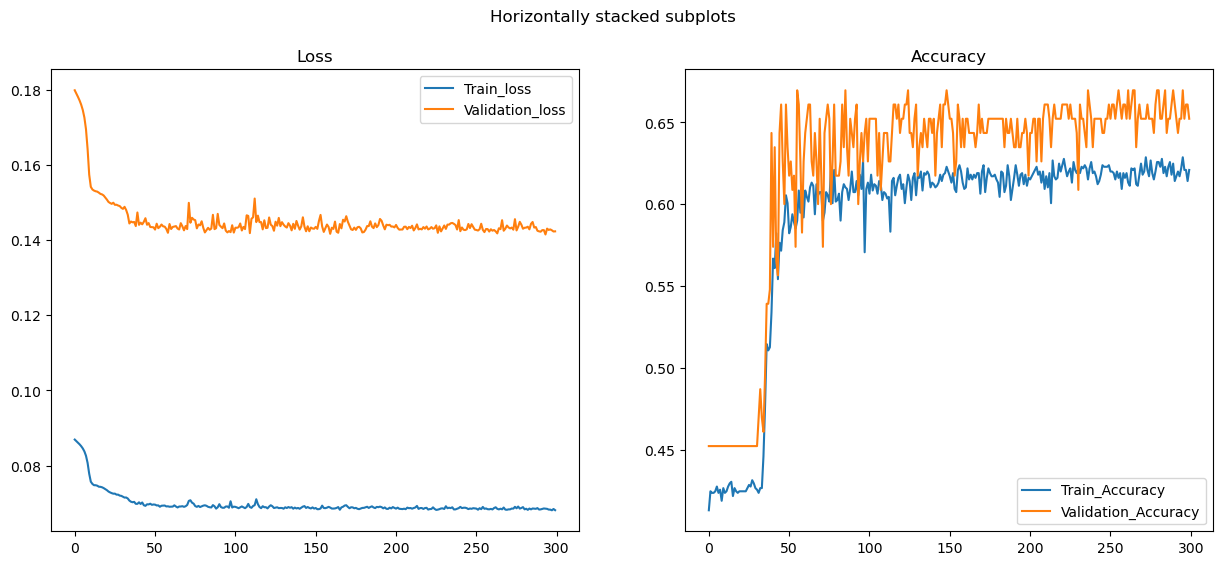

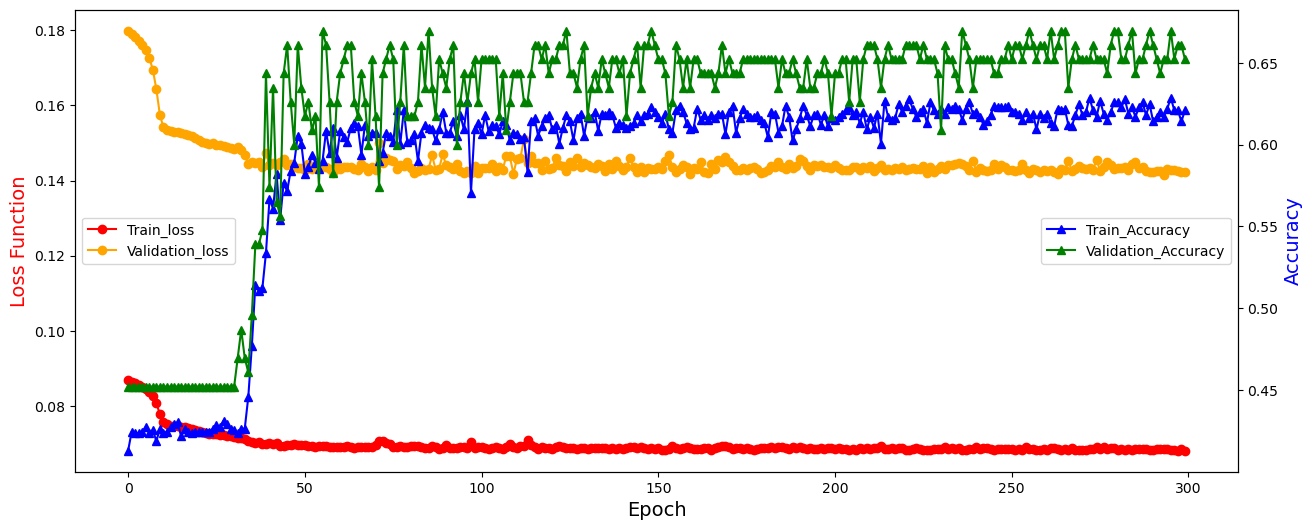

Current time: 90.414 minutes. Time expected till completion: 60.276 minutes

Epoch 301 of 500


100%|██████████| 15/15 [00:00<00:00, 17.72it/s]


train loss:  0.06857452390272337
Val loss:  0.14339951432269551
train accuracy:  0.6170212765957447
Val accuracy:  0.6608695652173913
Current time: 90.709 minutes. Time expected till completion: 59.970 minutes

Epoch 302 of 500


100%|██████████| 15/15 [00:00<00:00, 17.17it/s]


train loss:  0.06834921327273666
Val loss:  0.1418331633443418
train accuracy:  0.620889748549323
Val accuracy:  0.6434782608695652
Current time: 91.005 minutes. Time expected till completion: 59.665 minutes

Epoch 303 of 500


100%|██████████| 15/15 [00:00<00:00, 17.05it/s]


train loss:  0.06816718541446
Val loss:  0.14288317120593527
train accuracy:  0.6141199226305609
Val accuracy:  0.6434782608695652
Current time: 91.299 minutes. Time expected till completion: 59.360 minutes

Epoch 304 of 500


100%|██████████| 15/15 [00:00<00:00, 17.35it/s]


train loss:  0.06813956817298608
Val loss:  0.14232678672541743
train accuracy:  0.6199226305609284
Val accuracy:  0.6521739130434783
Current time: 91.599 minutes. Time expected till completion: 59.057 minutes

Epoch 305 of 500


100%|██████████| 15/15 [00:00<00:00, 17.23it/s]


train loss:  0.06839168861479547
Val loss:  0.14245866277943486
train accuracy:  0.6228239845261122
Val accuracy:  0.6521739130434783
Current time: 91.895 minutes. Time expected till completion: 58.752 minutes

Epoch 306 of 500


100%|██████████| 15/15 [00:00<00:00, 17.47it/s]


train loss:  0.06834750024446896
Val loss:  0.14339205596757973
train accuracy:  0.6179883945841392
Val accuracy:  0.6695652173913044
Current time: 92.188 minutes. Time expected till completion: 58.446 minutes

Epoch 307 of 500


100%|██████████| 15/15 [00:00<00:00, 17.55it/s]


train loss:  0.06887751172082336
Val loss:  0.14497524448063062
train accuracy:  0.6150870406189555
Val accuracy:  0.6521739130434783
Current time: 92.483 minutes. Time expected till completion: 58.141 minutes

Epoch 308 of 500


100%|██████████| 15/15 [00:00<00:00, 17.69it/s]


train loss:  0.06841716642997712
Val loss:  0.14231606618217799
train accuracy:  0.625725338491296
Val accuracy:  0.6695652173913044
Current time: 92.780 minutes. Time expected till completion: 57.837 minutes

Epoch 309 of 500


100%|██████████| 15/15 [00:00<00:00, 17.47it/s]


train loss:  0.06836718528367565
Val loss:  0.14199867922326792
train accuracy:  0.6218568665377177
Val accuracy:  0.6608695652173913
Current time: 93.072 minutes. Time expected till completion: 57.530 minutes

Epoch 310 of 500


100%|██████████| 15/15 [00:00<00:00, 17.09it/s]


train loss:  0.06849247021186283
Val loss:  0.14233456020769866
train accuracy:  0.6247582205029013
Val accuracy:  0.6521739130434783
Current time: 93.370 minutes. Time expected till completion: 57.227 minutes

Epoch 311 of 500


100%|██████████| 15/15 [00:00<00:00, 17.27it/s]


train loss:  0.06828031998768996
Val loss:  0.1426582818445952
train accuracy:  0.6228239845261122
Val accuracy:  0.6521739130434783
Current time: 93.665 minutes. Time expected till completion: 56.922 minutes

Epoch 312 of 500


100%|██████████| 15/15 [00:00<00:00, 16.92it/s]


train loss:  0.06838925571921255
Val loss:  0.1426342590995457
train accuracy:  0.6199226305609284
Val accuracy:  0.6608695652173913
Current time: 93.958 minutes. Time expected till completion: 56.616 minutes

Epoch 313 of 500


100%|██████████| 15/15 [00:00<00:00, 16.92it/s]


train loss:  0.06859115550089159
Val loss:  0.1421764207922894
train accuracy:  0.6237911025145068
Val accuracy:  0.6695652173913044
Current time: 94.253 minutes. Time expected till completion: 56.311 minutes

Epoch 314 of 500


100%|██████████| 15/15 [00:00<00:00, 17.37it/s]


train loss:  0.06834760256385435
Val loss:  0.14282421443773352
train accuracy:  0.6218568665377177
Val accuracy:  0.6521739130434783
Current time: 94.546 minutes. Time expected till completion: 56.005 minutes

Epoch 315 of 500


100%|██████████| 15/15 [00:00<00:00, 17.53it/s]


train loss:  0.06823931648837298
Val loss:  0.1433353154555611
train accuracy:  0.6228239845261122
Val accuracy:  0.6521739130434783
Current time: 94.840 minutes. Time expected till completion: 55.700 minutes

Epoch 316 of 500


100%|██████████| 15/15 [00:00<00:00, 17.37it/s]


train loss:  0.068390882280394
Val loss:  0.14242989809616752
train accuracy:  0.620889748549323
Val accuracy:  0.6521739130434783
Current time: 95.134 minutes. Time expected till completion: 55.394 minutes

Epoch 317 of 500


100%|██████████| 15/15 [00:00<00:00, 17.53it/s]


train loss:  0.06844790138635691
Val loss:  0.14301229870837667
train accuracy:  0.620889748549323
Val accuracy:  0.6521739130434783
Current time: 95.430 minutes. Time expected till completion: 55.091 minutes

Epoch 318 of 500


100%|██████████| 15/15 [00:00<00:00, 17.41it/s]


train loss:  0.06819323350889771
Val loss:  0.1450992542764415
train accuracy:  0.6160541586073501
Val accuracy:  0.6608695652173913
Current time: 95.725 minutes. Time expected till completion: 54.786 minutes

Epoch 319 of 500


100%|██████████| 15/15 [00:00<00:00, 17.51it/s]


train loss:  0.06872182254403887
Val loss:  0.14299113232156505
train accuracy:  0.6237911025145068
Val accuracy:  0.6521739130434783
Current time: 96.019 minutes. Time expected till completion: 54.481 minutes

Epoch 320 of 500


100%|██████████| 15/15 [00:00<00:00, 17.59it/s]


train loss:  0.06817431001414183
Val loss:  0.14342782497406006
train accuracy:  0.6199226305609284
Val accuracy:  0.6521739130434783
Current time: 96.313 minutes. Time expected till completion: 54.176 minutes

Epoch 321 of 500


100%|██████████| 15/15 [00:00<00:00, 16.64it/s]


train loss:  0.06873103428624816
Val loss:  0.14560042256894318
train accuracy:  0.6121856866537717
Val accuracy:  0.6521739130434783
Current time: 96.613 minutes. Time expected till completion: 53.874 minutes

Epoch 322 of 500


100%|██████████| 15/15 [00:00<00:00, 16.88it/s]


train loss:  0.06883728002671809
Val loss:  0.14293700301128884
train accuracy:  0.6054158607350096
Val accuracy:  0.6521739130434783
Current time: 96.909 minutes. Time expected till completion: 53.571 minutes

Epoch 323 of 500


100%|██████████| 15/15 [00:00<00:00, 17.49it/s]


train loss:  0.06856146777621551
Val loss:  0.14331316066824873
train accuracy:  0.6237911025145068
Val accuracy:  0.6608695652173913
Current time: 97.205 minutes. Time expected till completion: 53.267 minutes

Epoch 324 of 500


100%|██████████| 15/15 [00:00<00:00, 16.86it/s]


train loss:  0.0685486534693255
Val loss:  0.15830684122831926
train accuracy:  0.6170212765957447
Val accuracy:  0.5304347826086957
Current time: 97.504 minutes. Time expected till completion: 52.965 minutes

Epoch 325 of 500


100%|██████████| 15/15 [00:00<00:00, 17.33it/s]


train loss:  0.06930499069925895
Val loss:  0.14177001662876296
train accuracy:  0.5889748549323017
Val accuracy:  0.6608695652173913
Current time: 97.801 minutes. Time expected till completion: 52.662 minutes

Epoch 326 of 500


100%|██████████| 15/15 [00:00<00:00, 17.35it/s]


train loss:  0.06884374188500632
Val loss:  0.14065124159273895
train accuracy:  0.6131528046421664
Val accuracy:  0.6260869565217392
Current time: 98.097 minutes. Time expected till completion: 52.359 minutes

Epoch 327 of 500


100%|██████████| 15/15 [00:00<00:00, 17.17it/s]


train loss:  0.06877103125103669
Val loss:  0.14185370362323263
train accuracy:  0.6092843326885881
Val accuracy:  0.6521739130434783
Current time: 98.393 minutes. Time expected till completion: 52.055 minutes

Epoch 328 of 500


100%|██████████| 15/15 [00:00<00:00, 17.23it/s]


train loss:  0.06823234897056447
Val loss:  0.14251771957977957
train accuracy:  0.6189555125725339
Val accuracy:  0.6608695652173913
Current time: 98.689 minutes. Time expected till completion: 51.752 minutes

Epoch 329 of 500


100%|██████████| 15/15 [00:00<00:00, 17.31it/s]


train loss:  0.06845384357745689
Val loss:  0.14308795410653818
train accuracy:  0.6189555125725339
Val accuracy:  0.6521739130434783
Current time: 98.986 minutes. Time expected till completion: 51.448 minutes

Epoch 330 of 500


100%|██████████| 15/15 [00:00<00:00, 16.82it/s]


train loss:  0.06859354608524698
Val loss:  0.14267941506012627
train accuracy:  0.6054158607350096
Val accuracy:  0.6521739130434783
Current time: 99.282 minutes. Time expected till completion: 51.145 minutes

Epoch 331 of 500


100%|██████████| 15/15 [00:00<00:00, 16.77it/s]


train loss:  0.06849620311126488
Val loss:  0.1427695429843405
train accuracy:  0.6218568665377177
Val accuracy:  0.6434782608695652
Current time: 99.579 minutes. Time expected till completion: 50.842 minutes

Epoch 332 of 500


100%|██████████| 15/15 [00:00<00:00, 17.19it/s]


train loss:  0.06800703885938028
Val loss:  0.14349196268164593
train accuracy:  0.6247582205029013
Val accuracy:  0.6347826086956522
Current time: 99.875 minutes. Time expected till completion: 50.539 minutes

Epoch 333 of 500


100%|██████████| 15/15 [00:00<00:00, 17.35it/s]


train loss:  0.0684858835527468
Val loss:  0.1435864604037741
train accuracy:  0.6121856866537717
Val accuracy:  0.6521739130434783
Current time: 100.171 minutes. Time expected till completion: 50.236 minutes

Epoch 334 of 500


100%|██████████| 15/15 [00:00<00:00, 17.23it/s]


train loss:  0.06868177473660364
Val loss:  0.14250033316404923
train accuracy:  0.6150870406189555
Val accuracy:  0.6608695652173913
Current time: 100.468 minutes. Time expected till completion: 49.933 minutes

Epoch 335 of 500


100%|██████████| 15/15 [00:00<00:00, 17.13it/s]


train loss:  0.0685270701317077
Val loss:  0.1414955170258232
train accuracy:  0.6131528046421664
Val accuracy:  0.6521739130434783
Current time: 100.765 minutes. Time expected till completion: 49.631 minutes

Epoch 336 of 500


100%|██████████| 15/15 [00:00<00:00, 17.29it/s]


train loss:  0.06869622517369933
Val loss:  0.14245641127876613
train accuracy:  0.6083172147001934
Val accuracy:  0.6521739130434783
Current time: 101.061 minutes. Time expected till completion: 49.328 minutes

Epoch 337 of 500


100%|██████████| 15/15 [00:00<00:00, 17.39it/s]


train loss:  0.06853736000319284
Val loss:  0.14290642945662788
train accuracy:  0.6218568665377177
Val accuracy:  0.6521739130434783
Current time: 101.359 minutes. Time expected till completion: 49.025 minutes

Epoch 338 of 500


100%|██████████| 15/15 [00:00<00:00, 17.09it/s]


train loss:  0.06866004751775436
Val loss:  0.14522997659185657
train accuracy:  0.6228239845261122
Val accuracy:  0.6434782608695652
Current time: 101.653 minutes. Time expected till completion: 48.721 minutes

Epoch 339 of 500


100%|██████████| 15/15 [00:00<00:00, 16.90it/s]


train loss:  0.06907061451408342
Val loss:  0.14529747237329899
train accuracy:  0.6141199226305609
Val accuracy:  0.6434782608695652
Current time: 101.948 minutes. Time expected till completion: 48.418 minutes

Epoch 340 of 500


100%|██████████| 15/15 [00:00<00:00, 16.82it/s]


train loss:  0.06915172525254625
Val loss:  0.14443315734033998
train accuracy:  0.620889748549323
Val accuracy:  0.6608695652173913
Current time: 102.247 minutes. Time expected till completion: 48.116 minutes

Epoch 341 of 500


100%|██████████| 15/15 [00:00<00:00, 17.07it/s]


train loss:  0.06862676552923781
Val loss:  0.1443304647570071
train accuracy:  0.6063829787234043
Val accuracy:  0.6434782608695652
Current time: 102.544 minutes. Time expected till completion: 47.814 minutes

Epoch 342 of 500


100%|██████████| 15/15 [00:00<00:00, 17.29it/s]


train loss:  0.06841559342074441
Val loss:  0.14246233027914296
train accuracy:  0.6199226305609284
Val accuracy:  0.6434782608695652
Current time: 102.840 minutes. Time expected till completion: 47.511 minutes

Epoch 343 of 500


100%|██████████| 15/15 [00:00<00:00, 17.17it/s]


train loss:  0.06845692059518751
Val loss:  0.1420988829239555
train accuracy:  0.6247582205029013
Val accuracy:  0.6521739130434783
Current time: 103.135 minutes. Time expected till completion: 47.207 minutes

Epoch 344 of 500


100%|██████████| 15/15 [00:00<00:00, 17.09it/s]


train loss:  0.06811468098564812
Val loss:  0.14164919438569443
train accuracy:  0.6199226305609284
Val accuracy:  0.6521739130434783
Current time: 103.429 minutes. Time expected till completion: 46.904 minutes

Epoch 345 of 500


100%|██████████| 15/15 [00:00<00:00, 17.15it/s]


train loss:  0.06882461294445355
Val loss:  0.144524129577305
train accuracy:  0.6034816247582205
Val accuracy:  0.6434782608695652
Current time: 103.725 minutes. Time expected till completion: 46.601 minutes

Epoch 346 of 500


100%|██████████| 15/15 [00:00<00:00, 17.69it/s]


train loss:  0.06884638524147713
Val loss:  0.14393520510714988
train accuracy:  0.6141199226305609
Val accuracy:  0.6434782608695652
Current time: 104.021 minutes. Time expected till completion: 46.298 minutes

Epoch 347 of 500


100%|██████████| 15/15 [00:00<00:00, 17.15it/s]


train loss:  0.06859599558251048
Val loss:  0.14282899628514828
train accuracy:  0.6189555125725339
Val accuracy:  0.6521739130434783
Current time: 104.315 minutes. Time expected till completion: 45.995 minutes

Epoch 348 of 500


100%|██████████| 15/15 [00:00<00:00, 16.80it/s]


train loss:  0.06834917759065241
Val loss:  0.14481613532356594
train accuracy:  0.620889748549323
Val accuracy:  0.6521739130434783
Current time: 104.610 minutes. Time expected till completion: 45.692 minutes

Epoch 349 of 500


100%|██████████| 15/15 [00:00<00:00, 16.69it/s]


train loss:  0.06865716856729592
Val loss:  0.14306392306866852
train accuracy:  0.6286266924564797
Val accuracy:  0.6347826086956522
Current time: 104.906 minutes. Time expected till completion: 45.389 minutes

Epoch 350 of 500


100%|██████████| 15/15 [00:00<00:00, 17.27it/s]


train loss:  0.06839475191308175
Val loss:  0.14260994973389998
train accuracy:  0.620889748549323
Val accuracy:  0.6521739130434783
Current time: 105.202 minutes. Time expected till completion: 45.086 minutes

Epoch 351 of 500


100%|██████████| 15/15 [00:00<00:00, 17.07it/s]


train loss:  0.06834465553497669
Val loss:  0.14322746007338813
train accuracy:  0.6131528046421664
Val accuracy:  0.6434782608695652
Current time: 105.498 minutes. Time expected till completion: 44.784 minutes

Epoch 352 of 500


100%|██████████| 15/15 [00:00<00:00, 17.31it/s]


train loss:  0.06863087139000515
Val loss:  0.14367529983105867
train accuracy:  0.6141199226305609
Val accuracy:  0.6434782608695652
Current time: 105.793 minutes. Time expected till completion: 44.481 minutes

Epoch 353 of 500


100%|██████████| 15/15 [00:00<00:00, 17.17it/s]


train loss:  0.0682061909476378
Val loss:  0.1435822113700535
train accuracy:  0.620889748549323
Val accuracy:  0.6434782608695652
Current time: 106.087 minutes. Time expected till completion: 44.178 minutes

Epoch 354 of 500


100%|██████████| 15/15 [00:00<00:00, 17.25it/s]


train loss:  0.06836780842314376
Val loss:  0.14359962836555812
train accuracy:  0.6237911025145068
Val accuracy:  0.6434782608695652
Current time: 106.381 minutes. Time expected till completion: 43.875 minutes

Epoch 355 of 500


100%|██████████| 15/15 [00:00<00:00, 17.55it/s]


train loss:  0.06872863390228966
Val loss:  0.14308906949084738
train accuracy:  0.6237911025145068
Val accuracy:  0.6434782608695652
Current time: 106.681 minutes. Time expected till completion: 43.574 minutes

Epoch 356 of 500


100%|██████████| 15/15 [00:00<00:00, 17.13it/s]


train loss:  0.06830533139940849
Val loss:  0.143441859535549
train accuracy:  0.6228239845261122
Val accuracy:  0.6521739130434783
Current time: 106.983 minutes. Time expected till completion: 43.274 minutes

Epoch 357 of 500


100%|██████████| 15/15 [00:00<00:00, 16.86it/s]


train loss:  0.06847621024923121
Val loss:  0.14317971416141675
train accuracy:  0.6189555125725339
Val accuracy:  0.6521739130434783
Current time: 107.277 minutes. Time expected till completion: 42.971 minutes

Epoch 358 of 500


100%|██████████| 15/15 [00:00<00:00, 16.69it/s]


train loss:  0.06845886057073419
Val loss:  0.14408530256022578
train accuracy:  0.620889748549323
Val accuracy:  0.6434782608695652
Current time: 107.573 minutes. Time expected till completion: 42.669 minutes

Epoch 359 of 500


100%|██████████| 15/15 [00:00<00:00, 17.17it/s]


train loss:  0.06827048481778895
Val loss:  0.1431914738986803
train accuracy:  0.6218568665377177
Val accuracy:  0.6521739130434783
Current time: 107.869 minutes. Time expected till completion: 42.366 minutes

Epoch 360 of 500


100%|██████████| 15/15 [00:00<00:00, 17.37it/s]


train loss:  0.06813683321904859
Val loss:  0.1419683373492697
train accuracy:  0.6266924564796905
Val accuracy:  0.6521739130434783
Current time: 108.162 minutes. Time expected till completion: 42.063 minutes

Epoch 361 of 500


100%|██████████| 15/15 [00:00<00:00, 17.05it/s]


train loss:  0.06855210442838171
Val loss:  0.14286554637162582
train accuracy:  0.6121856866537717
Val accuracy:  0.6521739130434783
Current time: 108.456 minutes. Time expected till completion: 41.760 minutes

Epoch 362 of 500


100%|██████████| 15/15 [00:00<00:00, 17.51it/s]


train loss:  0.067856754970735
Val loss:  0.14302444976309073
train accuracy:  0.6189555125725339
Val accuracy:  0.6521739130434783
Current time: 108.750 minutes. Time expected till completion: 41.457 minutes

Epoch 363 of 500


100%|██████████| 15/15 [00:00<00:00, 17.15it/s]


train loss:  0.06835495290027596
Val loss:  0.14377312971198042
train accuracy:  0.6228239845261122
Val accuracy:  0.6434782608695652
Current time: 109.046 minutes. Time expected till completion: 41.155 minutes

Epoch 364 of 500


100%|██████████| 15/15 [00:00<00:00, 17.21it/s]


train loss:  0.06858972948570546
Val loss:  0.14270721207494322
train accuracy:  0.6131528046421664
Val accuracy:  0.6434782608695652
Current time: 109.340 minutes. Time expected till completion: 40.852 minutes

Epoch 365 of 500


100%|██████████| 15/15 [00:00<00:00, 17.19it/s]


train loss:  0.06873126146410605
Val loss:  0.14335206176923668
train accuracy:  0.6247582205029013
Val accuracy:  0.6608695652173913
Current time: 109.637 minutes. Time expected till completion: 40.551 minutes

Epoch 366 of 500


100%|██████████| 15/15 [00:00<00:00, 17.15it/s]


train loss:  0.06851284531606235
Val loss:  0.1472028032593105
train accuracy:  0.6189555125725339
Val accuracy:  0.6608695652173913
Current time: 109.933 minutes. Time expected till completion: 40.249 minutes

Epoch 367 of 500


100%|██████████| 15/15 [00:00<00:00, 16.96it/s]


train loss:  0.06844728187850642
Val loss:  0.14382598400115967
train accuracy:  0.6237911025145068
Val accuracy:  0.6695652173913044
Current time: 110.228 minutes. Time expected till completion: 39.946 minutes

Epoch 368 of 500


100%|██████████| 15/15 [00:00<00:00, 17.19it/s]


train loss:  0.0691060965134973
Val loss:  0.14312163591384888
train accuracy:  0.6063829787234043
Val accuracy:  0.6521739130434783
Current time: 110.525 minutes. Time expected till completion: 39.645 minutes

Epoch 369 of 500


100%|██████████| 15/15 [00:00<00:00, 17.17it/s]


train loss:  0.06851017198433498
Val loss:  0.14229239173557448
train accuracy:  0.6189555125725339
Val accuracy:  0.6608695652173913
Current time: 110.819 minutes. Time expected till completion: 39.342 minutes

Epoch 370 of 500


100%|██████████| 15/15 [00:00<00:00, 17.29it/s]


train loss:  0.06865202930955869
Val loss:  0.14271461445352304
train accuracy:  0.6063829787234043
Val accuracy:  0.6521739130434783
Current time: 111.114 minutes. Time expected till completion: 39.040 minutes

Epoch 371 of 500


100%|██████████| 15/15 [00:00<00:00, 17.39it/s]


train loss:  0.06809223355361525
Val loss:  0.1419274267943009
train accuracy:  0.620889748549323
Val accuracy:  0.6521739130434783
Current time: 111.407 minutes. Time expected till completion: 38.737 minutes

Epoch 372 of 500


100%|██████████| 15/15 [00:00<00:00, 17.78it/s]


train loss:  0.06847306728593616
Val loss:  0.1430599254110585
train accuracy:  0.6228239845261122
Val accuracy:  0.6521739130434783
Current time: 111.699 minutes. Time expected till completion: 38.434 minutes

Epoch 373 of 500


100%|██████████| 15/15 [00:00<00:00, 17.27it/s]


train loss:  0.06845042766639296
Val loss:  0.14386375105899313
train accuracy:  0.6199226305609284
Val accuracy:  0.6521739130434783
Current time: 111.995 minutes. Time expected till completion: 38.132 minutes

Epoch 374 of 500


100%|██████████| 15/15 [00:00<00:00, 17.47it/s]


train loss:  0.06860885208533857
Val loss:  0.1433434009552002
train accuracy:  0.6199226305609284
Val accuracy:  0.6608695652173913
Current time: 112.290 minutes. Time expected till completion: 37.830 minutes

Epoch 375 of 500


100%|██████████| 15/15 [00:00<00:00, 17.39it/s]


train loss:  0.0686443461324998
Val loss:  0.14291688100151392
train accuracy:  0.6189555125725339
Val accuracy:  0.6521739130434783
Current time: 112.585 minutes. Time expected till completion: 37.528 minutes

Epoch 376 of 500


100%|██████████| 15/15 [00:00<00:00, 17.03it/s]


train loss:  0.06840668794495455
Val loss:  0.14274910325589388
train accuracy:  0.6237911025145068
Val accuracy:  0.6521739130434783
Current time: 112.881 minutes. Time expected till completion: 37.227 minutes

Epoch 377 of 500


100%|██████████| 15/15 [00:00<00:00, 16.73it/s]


train loss:  0.06851959608970805
Val loss:  0.14355635953986126
train accuracy:  0.6189555125725339
Val accuracy:  0.6608695652173913
Current time: 113.177 minutes. Time expected till completion: 36.925 minutes

Epoch 378 of 500


100%|██████████| 15/15 [00:00<00:00, 17.29it/s]


train loss:  0.06833238130150726
Val loss:  0.14431946173958157
train accuracy:  0.6247582205029013
Val accuracy:  0.6521739130434783
Current time: 113.482 minutes. Time expected till completion: 36.626 minutes

Epoch 379 of 500


100%|██████████| 15/15 [00:00<00:00, 16.98it/s]


train loss:  0.06838563735987739
Val loss:  0.1430134047632632
train accuracy:  0.6160541586073501
Val accuracy:  0.6434782608695652
Current time: 113.776 minutes. Time expected till completion: 36.324 minutes

Epoch 380 of 500


100%|██████████| 15/15 [00:00<00:00, 17.41it/s]


train loss:  0.06848415605565335
Val loss:  0.1442047031029411
train accuracy:  0.6218568665377177
Val accuracy:  0.6521739130434783
Current time: 114.074 minutes. Time expected till completion: 36.023 minutes

Epoch 381 of 500


100%|██████████| 15/15 [00:00<00:00, 17.45it/s]


train loss:  0.0683013144268058
Val loss:  0.1436144196468851
train accuracy:  0.6199226305609284
Val accuracy:  0.6521739130434783
Current time: 114.368 minutes. Time expected till completion: 35.721 minutes

Epoch 382 of 500


100%|██████████| 15/15 [00:00<00:00, 17.21it/s]


train loss:  0.06843626205187932
Val loss:  0.14303829358971637
train accuracy:  0.6131528046421664
Val accuracy:  0.6521739130434783
Current time: 114.663 minutes. Time expected till completion: 35.419 minutes

Epoch 383 of 500


100%|██████████| 15/15 [00:00<00:00, 17.21it/s]


train loss:  0.0683308597113685
Val loss:  0.14280768840209299
train accuracy:  0.6150870406189555
Val accuracy:  0.6695652173913044
Current time: 114.956 minutes. Time expected till completion: 35.117 minutes

Epoch 384 of 500


100%|██████████| 15/15 [00:00<00:00, 17.53it/s]


train loss:  0.06846184155235438
Val loss:  0.14334256856337838
train accuracy:  0.620889748549323
Val accuracy:  0.6434782608695652
Current time: 115.254 minutes. Time expected till completion: 34.816 minutes

Epoch 385 of 500


100%|██████████| 15/15 [00:00<00:00, 17.03it/s]


train loss:  0.06822572657171946
Val loss:  0.1422344145567521
train accuracy:  0.620889748549323
Val accuracy:  0.6521739130434783
Current time: 115.547 minutes. Time expected till completion: 34.514 minutes

Epoch 386 of 500


100%|██████████| 15/15 [00:00<00:00, 16.92it/s]


train loss:  0.06833736497613402
Val loss:  0.14259018846180127
train accuracy:  0.620889748549323
Val accuracy:  0.6608695652173913
Current time: 115.839 minutes. Time expected till completion: 34.211 minutes

Epoch 387 of 500


100%|██████████| 15/15 [00:00<00:00, 17.59it/s]


train loss:  0.06830281192144988
Val loss:  0.14299000449802565
train accuracy:  0.6199226305609284
Val accuracy:  0.6521739130434783
Current time: 116.130 minutes. Time expected till completion: 33.909 minutes

Epoch 388 of 500


100%|██████████| 15/15 [00:00<00:00, 17.41it/s]


train loss:  0.06820680601684452
Val loss:  0.14248734505280206
train accuracy:  0.6237911025145068
Val accuracy:  0.6608695652173913
Current time: 116.422 minutes. Time expected till completion: 33.606 minutes

Epoch 389 of 500


100%|██████████| 15/15 [00:00<00:00, 17.29it/s]


train loss:  0.06866803079324718
Val loss:  0.14253835056139075
train accuracy:  0.6179883945841392
Val accuracy:  0.6521739130434783
Current time: 116.715 minutes. Time expected till completion: 33.304 minutes

Epoch 390 of 500


100%|██████████| 15/15 [00:00<00:00, 17.78it/s]


train loss:  0.0686406467823272
Val loss:  0.1434174553207729
train accuracy:  0.6218568665377177
Val accuracy:  0.6608695652173913
Current time: 117.007 minutes. Time expected till completion: 33.002 minutes

Epoch 391 of 500


100%|██████████| 15/15 [00:00<00:00, 17.72it/s]


train loss:  0.06861111752299782
Val loss:  0.14395134241684623
train accuracy:  0.6189555125725339
Val accuracy:  0.6434782608695652
Current time: 117.297 minutes. Time expected till completion: 32.699 minutes

Epoch 392 of 500


100%|██████████| 15/15 [00:00<00:00, 17.65it/s]


train loss:  0.06841530289133467
Val loss:  0.14143457205399224
train accuracy:  0.6199226305609284
Val accuracy:  0.6695652173913044
Current time: 117.587 minutes. Time expected till completion: 32.396 minutes

Epoch 393 of 500


100%|██████████| 15/15 [00:00<00:00, 17.23it/s]


train loss:  0.0681579846247483
Val loss:  0.14227649128955344
train accuracy:  0.620889748549323
Val accuracy:  0.6521739130434783
Current time: 117.880 minutes. Time expected till completion: 32.095 minutes

Epoch 394 of 500


100%|██████████| 15/15 [00:00<00:00, 17.55it/s]


train loss:  0.06830655940496715
Val loss:  0.1443281370660533
train accuracy:  0.6237911025145068
Val accuracy:  0.6608695652173913
Current time: 118.171 minutes. Time expected till completion: 31.792 minutes

Epoch 395 of 500


100%|██████████| 15/15 [00:00<00:00, 17.25it/s]


train loss:  0.06826660325264332
Val loss:  0.14252075941666312
train accuracy:  0.6266924564796905
Val accuracy:  0.6521739130434783
Current time: 118.464 minutes. Time expected till completion: 31.490 minutes

Epoch 396 of 500


100%|██████████| 15/15 [00:00<00:00, 17.15it/s]


train loss:  0.06807155771688982
Val loss:  0.14151823727980903
train accuracy:  0.6218568665377177
Val accuracy:  0.6434782608695652
Current time: 118.755 minutes. Time expected till completion: 31.188 minutes

Epoch 397 of 500


100%|██████████| 15/15 [00:00<00:00, 16.86it/s]


train loss:  0.06877249715637192
Val loss:  0.14285623094309932
train accuracy:  0.6160541586073501
Val accuracy:  0.6695652173913044
Current time: 119.050 minutes. Time expected till completion: 30.887 minutes

Epoch 398 of 500


100%|██████████| 15/15 [00:00<00:00, 17.43it/s]


train loss:  0.06845579802182934
Val loss:  0.14282241748726887
train accuracy:  0.6121856866537717
Val accuracy:  0.6608695652173913
Current time: 119.339 minutes. Time expected till completion: 30.584 minutes

Epoch 399 of 500


100%|██████████| 15/15 [00:00<00:00, 17.23it/s]


train loss:  0.06852559523379549
Val loss:  0.14286878212638524
train accuracy:  0.6102514506769826
Val accuracy:  0.6434782608695652
Current time: 119.628 minutes. Time expected till completion: 30.282 minutes

Epoch 400 of 500


100%|██████████| 15/15 [00:00<00:00, 16.82it/s]


train loss:  0.06827819733601244
Val loss:  0.14252363339714383
train accuracy:  0.6170212765957447
Val accuracy:  0.6521739130434783
Saving model checkpoint


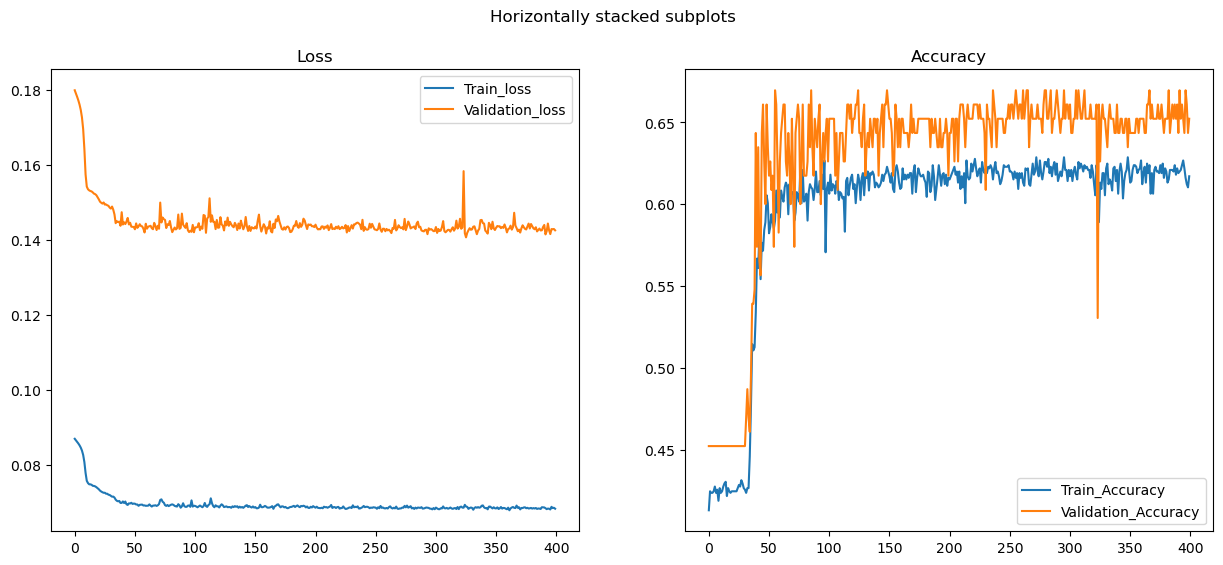

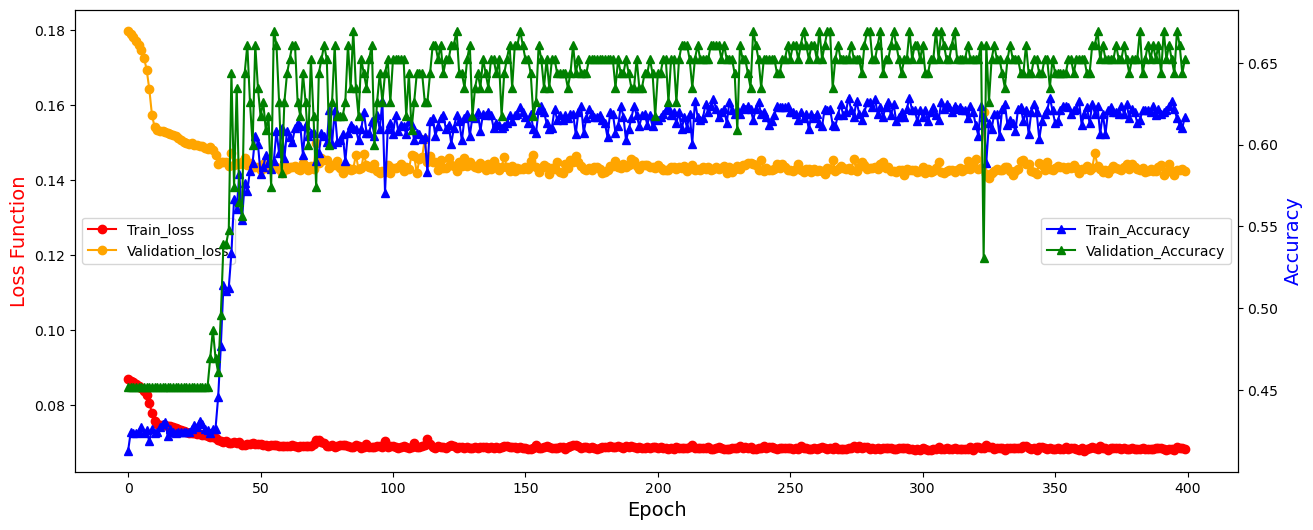

Current time: 119.934 minutes. Time expected till completion: 29.983 minutes

Epoch 401 of 500


100%|██████████| 15/15 [00:00<00:00, 17.61it/s]


train loss:  0.06825136348633978
Val loss:  0.14438468166019605
train accuracy:  0.6228239845261122
Val accuracy:  0.6434782608695652
Current time: 120.225 minutes. Time expected till completion: 29.682 minutes

Epoch 402 of 500


100%|██████████| 15/15 [00:00<00:00, 17.57it/s]


train loss:  0.0683827382337655
Val loss:  0.14291635181592857
train accuracy:  0.6179883945841392
Val accuracy:  0.6521739130434783
Current time: 120.519 minutes. Time expected till completion: 29.380 minutes

Epoch 403 of 500


100%|██████████| 15/15 [00:00<00:00, 17.37it/s]


train loss:  0.068216116562111
Val loss:  0.14378964227178823
train accuracy:  0.6266924564796905
Val accuracy:  0.6434782608695652
Current time: 120.808 minutes. Time expected till completion: 29.078 minutes

Epoch 404 of 500


100%|██████████| 15/15 [00:00<00:00, 17.39it/s]


train loss:  0.0687019950070741
Val loss:  0.14376331567764283
train accuracy:  0.6199226305609284
Val accuracy:  0.6521739130434783
Current time: 121.099 minutes. Time expected till completion: 28.776 minutes

Epoch 405 of 500


100%|██████████| 15/15 [00:00<00:00, 17.31it/s]


train loss:  0.0683635729193918
Val loss:  0.1439325503681017
train accuracy:  0.6218568665377177
Val accuracy:  0.6521739130434783
Current time: 121.390 minutes. Time expected till completion: 28.474 minutes

Epoch 406 of 500


100%|██████████| 15/15 [00:00<00:00, 17.07it/s]


train loss:  0.06814263590991612
Val loss:  0.14280967194101085
train accuracy:  0.6189555125725339
Val accuracy:  0.6608695652173913
Current time: 121.681 minutes. Time expected till completion: 28.173 minutes

Epoch 407 of 500


100%|██████████| 15/15 [00:00<00:00, 17.23it/s]


train loss:  0.06803670277678528
Val loss:  0.14289264264314072
train accuracy:  0.6141199226305609
Val accuracy:  0.6608695652173913
Current time: 121.977 minutes. Time expected till completion: 27.872 minutes

Epoch 408 of 500


100%|██████████| 15/15 [00:00<00:00, 17.15it/s]


train loss:  0.06835377735141629
Val loss:  0.1427200814952021
train accuracy:  0.6131528046421664
Val accuracy:  0.6521739130434783
Current time: 122.270 minutes. Time expected till completion: 27.571 minutes

Epoch 409 of 500


100%|██████████| 15/15 [00:00<00:00, 17.43it/s]


train loss:  0.06799049326714049
Val loss:  0.1426226662552875
train accuracy:  0.620889748549323
Val accuracy:  0.6521739130434783
Current time: 122.564 minutes. Time expected till completion: 27.270 minutes

Epoch 410 of 500


100%|██████████| 15/15 [00:00<00:00, 17.25it/s]


train loss:  0.0682917384275846
Val loss:  0.1434887232987777
train accuracy:  0.6247582205029013
Val accuracy:  0.6521739130434783
Current time: 122.859 minutes. Time expected till completion: 26.969 minutes

Epoch 411 of 500


100%|██████████| 15/15 [00:00<00:00, 17.37it/s]


train loss:  0.06812843565092326
Val loss:  0.14223078385643337
train accuracy:  0.6276595744680851
Val accuracy:  0.6434782608695652
Current time: 123.154 minutes. Time expected till completion: 26.668 minutes

Epoch 412 of 500


100%|██████████| 15/15 [00:00<00:00, 17.33it/s]


train loss:  0.06863483751996112
Val loss:  0.14359765467436417
train accuracy:  0.6131528046421664
Val accuracy:  0.6521739130434783
Current time: 123.450 minutes. Time expected till completion: 26.368 minutes

Epoch 413 of 500


100%|██████████| 15/15 [00:00<00:00, 16.99it/s]


train loss:  0.06878462894972796
Val loss:  0.14244053415630176
train accuracy:  0.6218568665377177
Val accuracy:  0.6434782608695652
Current time: 123.747 minutes. Time expected till completion: 26.068 minutes

Epoch 414 of 500


100%|██████████| 15/15 [00:00<00:00, 17.31it/s]


train loss:  0.06839801760199453
Val loss:  0.1427078506220942
train accuracy:  0.6218568665377177
Val accuracy:  0.6521739130434783
Current time: 124.045 minutes. Time expected till completion: 25.768 minutes

Epoch 415 of 500


100%|██████████| 15/15 [00:00<00:00, 16.73it/s]


train loss:  0.06911766846129234
Val loss:  0.1466161935225777
train accuracy:  0.5967117988394585
Val accuracy:  0.6
Current time: 124.341 minutes. Time expected till completion: 25.468 minutes

Epoch 416 of 500


100%|██████████| 15/15 [00:00<00:00, 16.84it/s]


train loss:  0.06880603814263409
Val loss:  0.1449270953302798
train accuracy:  0.6150870406189555
Val accuracy:  0.6521739130434783
Current time: 124.638 minutes. Time expected till completion: 25.167 minutes

Epoch 417 of 500


100%|██████████| 15/15 [00:00<00:00, 17.45it/s]


train loss:  0.06832170532565975
Val loss:  0.1431906440983648
train accuracy:  0.6247582205029013
Val accuracy:  0.6521739130434783
Current time: 124.936 minutes. Time expected till completion: 24.867 minutes

Epoch 418 of 500


100%|██████████| 15/15 [00:00<00:00, 17.29it/s]


train loss:  0.06807357741509
Val loss:  0.1440504825633505
train accuracy:  0.6237911025145068
Val accuracy:  0.6521739130434783
Current time: 125.231 minutes. Time expected till completion: 24.567 minutes

Epoch 419 of 500


100%|██████████| 15/15 [00:00<00:00, 17.29it/s]


train loss:  0.06880834237519269
Val loss:  0.1444901300513226
train accuracy:  0.6160541586073501
Val accuracy:  0.6434782608695652
Current time: 125.530 minutes. Time expected till completion: 24.267 minutes

Epoch 420 of 500


100%|██████████| 15/15 [00:00<00:00, 17.15it/s]


train loss:  0.06825054325955979
Val loss:  0.14266273405240928
train accuracy:  0.6247582205029013
Val accuracy:  0.6521739130434783
Current time: 125.827 minutes. Time expected till completion: 23.967 minutes

Epoch 421 of 500


100%|██████████| 15/15 [00:00<00:00, 17.37it/s]


train loss:  0.06841061095665686
Val loss:  0.1427680077760116
train accuracy:  0.6179883945841392
Val accuracy:  0.6434782608695652
Current time: 126.124 minutes. Time expected till completion: 23.667 minutes

Epoch 422 of 500


100%|██████████| 15/15 [00:00<00:00, 17.19it/s]


train loss:  0.06823325969956139
Val loss:  0.14321457147598265
train accuracy:  0.6276595744680851
Val accuracy:  0.6608695652173913
Current time: 126.422 minutes. Time expected till completion: 23.367 minutes

Epoch 423 of 500


100%|██████████| 15/15 [00:00<00:00, 17.33it/s]


train loss:  0.0680322807923507
Val loss:  0.14351966070092242
train accuracy:  0.6189555125725339
Val accuracy:  0.6521739130434783
Current time: 126.722 minutes. Time expected till completion: 23.068 minutes

Epoch 424 of 500


100%|██████████| 15/15 [00:00<00:00, 16.94it/s]


train loss:  0.06815024449470196
Val loss:  0.1427795674489892
train accuracy:  0.6228239845261122
Val accuracy:  0.6695652173913044
Current time: 127.020 minutes. Time expected till completion: 22.768 minutes

Epoch 425 of 500


100%|██████████| 15/15 [00:00<00:00, 16.96it/s]


train loss:  0.06813862977452158
Val loss:  0.1433407099350639
train accuracy:  0.6179883945841392
Val accuracy:  0.6608695652173913
Current time: 127.318 minutes. Time expected till completion: 22.468 minutes

Epoch 426 of 500


100%|██████████| 15/15 [00:00<00:00, 17.27it/s]


train loss:  0.0681216761152795
Val loss:  0.14248957271161286
train accuracy:  0.625725338491296
Val accuracy:  0.6521739130434783
Current time: 127.617 minutes. Time expected till completion: 22.168 minutes

Epoch 427 of 500


100%|██████████| 15/15 [00:00<00:00, 17.41it/s]


train loss:  0.06802978385347923
Val loss:  0.14289853780165962
train accuracy:  0.6276595744680851
Val accuracy:  0.6521739130434783
Current time: 127.914 minutes. Time expected till completion: 21.868 minutes

Epoch 428 of 500


100%|██████████| 15/15 [00:00<00:00, 17.35it/s]


train loss:  0.06835959520284626
Val loss:  0.14361192558122718
train accuracy:  0.6276595744680851
Val accuracy:  0.6521739130434783
Current time: 128.212 minutes. Time expected till completion: 21.568 minutes

Epoch 429 of 500


100%|██████████| 15/15 [00:00<00:00, 17.17it/s]


train loss:  0.06808576333684202
Val loss:  0.14375425110692563
train accuracy:  0.6228239845261122
Val accuracy:  0.6521739130434783
Current time: 128.511 minutes. Time expected till completion: 21.269 minutes

Epoch 430 of 500


100%|██████████| 15/15 [00:00<00:00, 17.21it/s]


train loss:  0.06921395463454655
Val loss:  0.14338539164999256
train accuracy:  0.6112185686653772
Val accuracy:  0.6608695652173913
Current time: 128.810 minutes. Time expected till completion: 20.969 minutes

Epoch 431 of 500


100%|██████████| 15/15 [00:00<00:00, 17.43it/s]


train loss:  0.06832884635408797
Val loss:  0.14100061758704807
train accuracy:  0.6150870406189555
Val accuracy:  0.6608695652173913
Current time: 129.107 minutes. Time expected till completion: 20.669 minutes

Epoch 432 of 500


100%|██████████| 15/15 [00:00<00:00, 16.80it/s]


train loss:  0.06802885738747264
Val loss:  0.14226426041644552
train accuracy:  0.6189555125725339
Val accuracy:  0.6434782608695652
Current time: 129.406 minutes. Time expected till completion: 20.369 minutes

Epoch 433 of 500


100%|██████████| 15/15 [00:00<00:00, 16.80it/s]


train loss:  0.06800212804768486
Val loss:  0.14490127407986184
train accuracy:  0.6228239845261122
Val accuracy:  0.6434782608695652
Current time: 129.707 minutes. Time expected till completion: 20.070 minutes

Epoch 434 of 500


100%|██████████| 15/15 [00:00<00:00, 17.19it/s]


train loss:  0.06854894601630057
Val loss:  0.142328549467999
train accuracy:  0.6189555125725339
Val accuracy:  0.6521739130434783
Current time: 130.007 minutes. Time expected till completion: 19.771 minutes

Epoch 435 of 500


100%|██████████| 15/15 [00:00<00:00, 17.45it/s]


train loss:  0.06822824835546704
Val loss:  0.14392256684925245
train accuracy:  0.6170212765957447
Val accuracy:  0.6434782608695652
Current time: 130.303 minutes. Time expected till completion: 19.471 minutes

Epoch 436 of 500


100%|██████████| 15/15 [00:00<00:00, 17.11it/s]


train loss:  0.06823539491778877
Val loss:  0.142884273632713
train accuracy:  0.6199226305609284
Val accuracy:  0.6521739130434783
Current time: 130.602 minutes. Time expected till completion: 19.171 minutes

Epoch 437 of 500


100%|██████████| 15/15 [00:00<00:00, 17.39it/s]


train loss:  0.06824435780772388
Val loss:  0.14362961209338646
train accuracy:  0.6189555125725339
Val accuracy:  0.6434782608695652
Current time: 130.899 minutes. Time expected till completion: 18.871 minutes

Epoch 438 of 500


100%|██████████| 15/15 [00:00<00:00, 17.25it/s]


train loss:  0.0679288750921504
Val loss:  0.14299707205399223
train accuracy:  0.6247582205029013
Val accuracy:  0.6521739130434783
Current time: 131.196 minutes. Time expected till completion: 18.571 minutes

Epoch 439 of 500


100%|██████████| 15/15 [00:00<00:00, 17.29it/s]


train loss:  0.0687170433352487
Val loss:  0.14213502407073975
train accuracy:  0.6150870406189555
Val accuracy:  0.6521739130434783
Current time: 131.494 minutes. Time expected till completion: 18.271 minutes

Epoch 440 of 500


100%|██████████| 15/15 [00:00<00:00, 17.09it/s]


train loss:  0.06836048321982187
Val loss:  0.14259749599125074
train accuracy:  0.6247582205029013
Val accuracy:  0.6521739130434783
Current time: 131.793 minutes. Time expected till completion: 17.972 minutes

Epoch 441 of 500


100%|██████████| 15/15 [00:00<00:00, 16.96it/s]


train loss:  0.06795892015647151
Val loss:  0.14210800450781116
train accuracy:  0.6247582205029013
Val accuracy:  0.6434782608695652
Current time: 132.091 minutes. Time expected till completion: 17.672 minutes

Epoch 442 of 500


100%|██████████| 15/15 [00:00<00:00, 16.80it/s]


train loss:  0.06834318876497059
Val loss:  0.1430342435836792
train accuracy:  0.6218568665377177
Val accuracy:  0.6434782608695652
Current time: 132.389 minutes. Time expected till completion: 17.372 minutes

Epoch 443 of 500


100%|██████████| 15/15 [00:00<00:00, 17.41it/s]


train loss:  0.06882017775937713
Val loss:  0.14277948711229407
train accuracy:  0.6092843326885881
Val accuracy:  0.6521739130434783
Current time: 132.687 minutes. Time expected till completion: 17.073 minutes

Epoch 444 of 500


100%|██████████| 15/15 [00:00<00:00, 17.41it/s]


train loss:  0.06841128949270488
Val loss:  0.1430046128190082
train accuracy:  0.6160541586073501
Val accuracy:  0.6608695652173913
Current time: 132.985 minutes. Time expected till completion: 16.773 minutes

Epoch 445 of 500


100%|██████████| 15/15 [00:00<00:00, 17.31it/s]


train loss:  0.06885805264893537
Val loss:  0.14327444719231647
train accuracy:  0.6044487427466151
Val accuracy:  0.6521739130434783
Current time: 133.282 minutes. Time expected till completion: 16.473 minutes

Epoch 446 of 500


100%|██████████| 15/15 [00:00<00:00, 17.15it/s]


train loss:  0.06856113084280284
Val loss:  0.1444547984911048
train accuracy:  0.6073500967117988
Val accuracy:  0.6521739130434783
Current time: 133.578 minutes. Time expected till completion: 16.173 minutes

Epoch 447 of 500


100%|██████████| 15/15 [00:00<00:00, 17.55it/s]


train loss:  0.06882325846637011
Val loss:  0.14257942075314728
train accuracy:  0.6131528046421664
Val accuracy:  0.6521739130434783
Current time: 133.876 minutes. Time expected till completion: 15.873 minutes

Epoch 448 of 500


100%|██████████| 15/15 [00:00<00:00, 17.25it/s]


train loss:  0.06832559363523812
Val loss:  0.14259339674659396
train accuracy:  0.625725338491296
Val accuracy:  0.6521739130434783
Current time: 134.175 minutes. Time expected till completion: 15.574 minutes

Epoch 449 of 500


100%|██████████| 15/15 [00:00<00:00, 16.84it/s]


train loss:  0.06878777047190492
Val loss:  0.14262240658635678
train accuracy:  0.6131528046421664
Val accuracy:  0.6521739130434783
Current time: 134.473 minutes. Time expected till completion: 15.274 minutes

Epoch 450 of 500


100%|██████████| 15/15 [00:00<00:00, 16.80it/s]


train loss:  0.06818274839473186
Val loss:  0.14252985871356466
train accuracy:  0.6218568665377177
Val accuracy:  0.6695652173913044
Current time: 134.773 minutes. Time expected till completion: 14.975 minutes

Epoch 451 of 500


100%|██████████| 15/15 [00:00<00:00, 17.15it/s]


train loss:  0.06831475025911166
Val loss:  0.14202809230141017
train accuracy:  0.6199226305609284
Val accuracy:  0.6521739130434783
Current time: 135.071 minutes. Time expected till completion: 14.675 minutes

Epoch 452 of 500


100%|██████████| 15/15 [00:00<00:00, 17.43it/s]


train loss:  0.06832891691123033
Val loss:  0.1426569057547528
train accuracy:  0.6247582205029013
Val accuracy:  0.6434782608695652
Current time: 135.367 minutes. Time expected till completion: 14.375 minutes

Epoch 453 of 500


100%|██████████| 15/15 [00:00<00:00, 17.29it/s]


train loss:  0.06821243969338084
Val loss:  0.1431727777356687
train accuracy:  0.6228239845261122
Val accuracy:  0.6521739130434783
Current time: 135.665 minutes. Time expected till completion: 14.076 minutes

Epoch 454 of 500


100%|██████████| 15/15 [00:00<00:00, 17.17it/s]


train loss:  0.06812201748733594
Val loss:  0.14259321948756343
train accuracy:  0.6218568665377177
Val accuracy:  0.6695652173913044
Current time: 135.962 minutes. Time expected till completion: 13.776 minutes

Epoch 455 of 500


100%|██████████| 15/15 [00:00<00:00, 17.23it/s]


train loss:  0.06910881988084523
Val loss:  0.14275028912917428
train accuracy:  0.6102514506769826
Val accuracy:  0.6608695652173913
Current time: 136.258 minutes. Time expected till completion: 13.476 minutes

Epoch 456 of 500


100%|██████████| 15/15 [00:00<00:00, 17.23it/s]


train loss:  0.06864324333128201
Val loss:  0.14452323498933212
train accuracy:  0.6170212765957447
Val accuracy:  0.6434782608695652
Current time: 136.562 minutes. Time expected till completion: 13.177 minutes

Epoch 457 of 500


100%|██████████| 15/15 [00:00<00:00, 17.33it/s]


train loss:  0.06833958660380292
Val loss:  0.14370680321817814
train accuracy:  0.6121856866537717
Val accuracy:  0.6434782608695652
Current time: 136.860 minutes. Time expected till completion: 12.877 minutes

Epoch 458 of 500


100%|██████████| 15/15 [00:00<00:00, 16.73it/s]


train loss:  0.06839538122053533
Val loss:  0.14504921954611075
train accuracy:  0.6150870406189555
Val accuracy:  0.6434782608695652
Current time: 137.158 minutes. Time expected till completion: 12.578 minutes

Epoch 459 of 500


100%|██████████| 15/15 [00:00<00:00, 16.90it/s]


train loss:  0.0682522243526503
Val loss:  0.14479145278101382
train accuracy:  0.6189555125725339
Val accuracy:  0.6260869565217392
Current time: 137.456 minutes. Time expected till completion: 12.278 minutes

Epoch 460 of 500


100%|██████████| 15/15 [00:00<00:00, 17.11it/s]


train loss:  0.06834728805423936
Val loss:  0.14235961385395215
train accuracy:  0.6131528046421664
Val accuracy:  0.6434782608695652
Current time: 137.754 minutes. Time expected till completion: 11.979 minutes

Epoch 461 of 500


100%|██████████| 15/15 [00:00<00:00, 17.13it/s]


train loss:  0.06813314706951783
Val loss:  0.14383989676185277
train accuracy:  0.6305609284332688
Val accuracy:  0.6434782608695652
Current time: 138.052 minutes. Time expected till completion: 11.679 minutes

Epoch 462 of 500


100%|██████████| 15/15 [00:00<00:00, 17.21it/s]


train loss:  0.06836404589435349
Val loss:  0.1427881551825482
train accuracy:  0.6218568665377177
Val accuracy:  0.6608695652173913
Current time: 138.351 minutes. Time expected till completion: 11.380 minutes

Epoch 463 of 500


100%|██████████| 15/15 [00:00<00:00, 17.39it/s]


train loss:  0.06831917731628197
Val loss:  0.14401903256126072
train accuracy:  0.6237911025145068
Val accuracy:  0.6608695652173913
Current time: 138.654 minutes. Time expected till completion: 11.080 minutes

Epoch 464 of 500


100%|██████████| 15/15 [00:00<00:00, 17.25it/s]


train loss:  0.0685183008127563
Val loss:  0.14316656123036925
train accuracy:  0.625725338491296
Val accuracy:  0.6608695652173913
Current time: 138.951 minutes. Time expected till completion: 10.781 minutes

Epoch 465 of 500


100%|██████████| 15/15 [00:00<00:00, 17.59it/s]


train loss:  0.06845273783635816
Val loss:  0.14710798730020938
train accuracy:  0.6218568665377177
Val accuracy:  0.6521739130434783
Current time: 139.246 minutes. Time expected till completion: 10.481 minutes

Epoch 466 of 500


100%|██████████| 15/15 [00:00<00:00, 16.67it/s]


train loss:  0.06824931358230414
Val loss:  0.14178955036660898
train accuracy:  0.6266924564796905
Val accuracy:  0.6521739130434783
Current time: 139.543 minutes. Time expected till completion: 10.181 minutes

Epoch 467 of 500


100%|██████████| 15/15 [00:00<00:00, 17.01it/s]


train loss:  0.06816850299991999
Val loss:  0.14176992955415146
train accuracy:  0.620889748549323
Val accuracy:  0.6521739130434783
Current time: 139.840 minutes. Time expected till completion: 9.882 minutes

Epoch 468 of 500


100%|██████████| 15/15 [00:00<00:00, 17.13it/s]


train loss:  0.06877505243170423
Val loss:  0.1427442685417507
train accuracy:  0.6102514506769826
Val accuracy:  0.6608695652173913
Current time: 140.138 minutes. Time expected till completion: 9.582 minutes

Epoch 469 of 500


100%|██████████| 15/15 [00:00<00:00, 17.21it/s]


train loss:  0.06830376473109542
Val loss:  0.14246239092039026
train accuracy:  0.6199226305609284
Val accuracy:  0.6434782608695652
Current time: 140.434 minutes. Time expected till completion: 9.282 minutes

Epoch 470 of 500


100%|██████████| 15/15 [00:00<00:00, 17.39it/s]


train loss:  0.0683613617830627
Val loss:  0.14247822243234384
train accuracy:  0.6237911025145068
Val accuracy:  0.6434782608695652
Current time: 140.733 minutes. Time expected till completion: 8.983 minutes

Epoch 471 of 500


100%|██████████| 15/15 [00:00<00:00, 17.05it/s]


train loss:  0.06816525869719987
Val loss:  0.14182511101598325
train accuracy:  0.6189555125725339
Val accuracy:  0.6521739130434783
Current time: 141.031 minutes. Time expected till completion: 8.683 minutes

Epoch 472 of 500


100%|██████████| 15/15 [00:00<00:00, 17.23it/s]


train loss:  0.06770731569258802
Val loss:  0.14175013044606086
train accuracy:  0.6295938104448743
Val accuracy:  0.6521739130434783
Current time: 141.327 minutes. Time expected till completion: 8.384 minutes

Epoch 473 of 500


100%|██████████| 15/15 [00:00<00:00, 17.19it/s]


train loss:  0.06804066296933467
Val loss:  0.14213834223539934
train accuracy:  0.6295938104448743
Val accuracy:  0.6521739130434783
Current time: 141.622 minutes. Time expected till completion: 8.084 minutes

Epoch 474 of 500


100%|██████████| 15/15 [00:00<00:00, 17.17it/s]


train loss:  0.06818522129575334
Val loss:  0.14242453005002892
train accuracy:  0.6237911025145068
Val accuracy:  0.6521739130434783
Current time: 141.919 minutes. Time expected till completion: 7.785 minutes

Epoch 475 of 500


100%|██████████| 15/15 [00:00<00:00, 16.84it/s]


train loss:  0.06892602044793578
Val loss:  0.14355577956075255
train accuracy:  0.6170212765957447
Val accuracy:  0.6608695652173913
Current time: 142.216 minutes. Time expected till completion: 7.485 minutes

Epoch 476 of 500


100%|██████████| 15/15 [00:00<00:00, 16.71it/s]


train loss:  0.06826012479267453
Val loss:  0.141542068771694
train accuracy:  0.6228239845261122
Val accuracy:  0.6608695652173913
Current time: 142.512 minutes. Time expected till completion: 7.185 minutes

Epoch 477 of 500


100%|██████████| 15/15 [00:00<00:00, 17.37it/s]


train loss:  0.06851688575006776
Val loss:  0.14242817215297532
train accuracy:  0.620889748549323
Val accuracy:  0.6608695652173913
Current time: 142.810 minutes. Time expected till completion: 6.886 minutes

Epoch 478 of 500


100%|██████████| 15/15 [00:00<00:00, 17.53it/s]


train loss:  0.06844298936412228
Val loss:  0.1416833494020545
train accuracy:  0.6247582205029013
Val accuracy:  0.6521739130434783
Current time: 143.107 minutes. Time expected till completion: 6.586 minutes

Epoch 479 of 500


100%|██████████| 15/15 [00:00<00:00, 17.25it/s]


train loss:  0.06861448858646636
Val loss:  0.14164840553117836
train accuracy:  0.6179883945841392
Val accuracy:  0.6608695652173913
Current time: 143.402 minutes. Time expected till completion: 6.287 minutes

Epoch 480 of 500


100%|██████████| 15/15 [00:00<00:00, 17.23it/s]


train loss:  0.06822049029791148
Val loss:  0.1418858429659968
train accuracy:  0.6218568665377177
Val accuracy:  0.6608695652173913
Current time: 143.697 minutes. Time expected till completion: 5.987 minutes

Epoch 481 of 500


100%|██████████| 15/15 [00:00<00:00, 17.47it/s]


train loss:  0.06842534517872956
Val loss:  0.14216095571932585
train accuracy:  0.6247582205029013
Val accuracy:  0.6521739130434783
Current time: 143.991 minutes. Time expected till completion: 5.688 minutes

Epoch 482 of 500


100%|██████████| 15/15 [00:00<00:00, 17.27it/s]


train loss:  0.06821678881488409
Val loss:  0.14211181246716043
train accuracy:  0.6218568665377177
Val accuracy:  0.6521739130434783
Current time: 144.287 minutes. Time expected till completion: 5.388 minutes

Epoch 483 of 500


100%|██████████| 15/15 [00:00<00:00, 17.31it/s]


train loss:  0.06814393983357649
Val loss:  0.14188877551451973
train accuracy:  0.6228239845261122
Val accuracy:  0.6521739130434783
Current time: 144.586 minutes. Time expected till completion: 5.089 minutes

Epoch 484 of 500


100%|██████████| 15/15 [00:00<00:00, 17.01it/s]


train loss:  0.06780786100393107
Val loss:  0.142521435799806
train accuracy:  0.625725338491296
Val accuracy:  0.6608695652173913
Current time: 144.884 minutes. Time expected till completion: 4.790 minutes

Epoch 485 of 500


100%|██████████| 15/15 [00:00<00:00, 16.88it/s]


train loss:  0.06788069321062394
Val loss:  0.14194023401840875
train accuracy:  0.6228239845261122
Val accuracy:  0.6521739130434783
Current time: 145.180 minutes. Time expected till completion: 4.490 minutes

Epoch 486 of 500


100%|██████████| 15/15 [00:00<00:00, 17.41it/s]


train loss:  0.06831886050087801
Val loss:  0.1416816058366195
train accuracy:  0.6266924564796905
Val accuracy:  0.6521739130434783
Current time: 145.479 minutes. Time expected till completion: 4.191 minutes

Epoch 487 of 500


100%|██████████| 15/15 [00:00<00:00, 17.43it/s]


train loss:  0.06788539379201036
Val loss:  0.14179629139278246
train accuracy:  0.625725338491296
Val accuracy:  0.6521739130434783
Current time: 145.776 minutes. Time expected till completion: 3.891 minutes

Epoch 488 of 500


100%|██████████| 15/15 [00:00<00:00, 17.29it/s]


train loss:  0.06814369351767018
Val loss:  0.14266180784805962
train accuracy:  0.620889748549323
Val accuracy:  0.6608695652173913
Current time: 146.072 minutes. Time expected till completion: 3.592 minutes

Epoch 489 of 500


100%|██████████| 15/15 [00:00<00:00, 17.11it/s]


train loss:  0.06835029059498637
Val loss:  0.1438228472419407
train accuracy:  0.6247582205029013
Val accuracy:  0.6521739130434783
Current time: 146.367 minutes. Time expected till completion: 3.293 minutes

Epoch 490 of 500


100%|██████████| 15/15 [00:00<00:00, 17.39it/s]


train loss:  0.06832584427449874
Val loss:  0.1437142672746078
train accuracy:  0.625725338491296
Val accuracy:  0.6608695652173913
Current time: 146.665 minutes. Time expected till completion: 2.993 minutes

Epoch 491 of 500


100%|██████████| 15/15 [00:00<00:00, 17.13it/s]


train loss:  0.06821145869546517
Val loss:  0.14284156871878584
train accuracy:  0.6228239845261122
Val accuracy:  0.6434782608695652
Current time: 146.960 minutes. Time expected till completion: 2.694 minutes

Epoch 492 of 500


100%|██████████| 15/15 [00:00<00:00, 17.13it/s]


train loss:  0.06845904094107608
Val loss:  0.14277711899384207
train accuracy:  0.620889748549323
Val accuracy:  0.6434782608695652
Current time: 147.257 minutes. Time expected till completion: 2.394 minutes

Epoch 493 of 500


100%|██████████| 15/15 [00:00<00:00, 16.98it/s]


train loss:  0.06827138494015662
Val loss:  0.14344526736632637
train accuracy:  0.6218568665377177
Val accuracy:  0.6434782608695652
Current time: 147.555 minutes. Time expected till completion: 2.095 minutes

Epoch 494 of 500


100%|██████████| 15/15 [00:00<00:00, 16.86it/s]


train loss:  0.06841963183718447
Val loss:  0.14232068320979244
train accuracy:  0.620889748549323
Val accuracy:  0.6434782608695652
Current time: 147.850 minutes. Time expected till completion: 1.796 minutes

Epoch 495 of 500


100%|██████████| 15/15 [00:00<00:00, 17.25it/s]


train loss:  0.06832133213371558
Val loss:  0.14194850714310356
train accuracy:  0.6179883945841392
Val accuracy:  0.6521739130434783
Current time: 148.145 minutes. Time expected till completion: 1.496 minutes

Epoch 496 of 500


100%|██████████| 15/15 [00:00<00:00, 17.35it/s]


train loss:  0.06819603262141317
Val loss:  0.14244004487991332
train accuracy:  0.6160541586073501
Val accuracy:  0.6521739130434783
Current time: 148.441 minutes. Time expected till completion: 1.197 minutes

Epoch 497 of 500


100%|██████████| 15/15 [00:00<00:00, 16.99it/s]


train loss:  0.06799338703229303
Val loss:  0.1420291377150494
train accuracy:  0.620889748549323
Val accuracy:  0.6521739130434783
Current time: 148.738 minutes. Time expected till completion: 0.898 minutes

Epoch 498 of 500


100%|██████████| 15/15 [00:00<00:00, 17.21it/s]


train loss:  0.06821882159843666
Val loss:  0.14312780110732368
train accuracy:  0.6179883945841392
Val accuracy:  0.6521739130434783
Current time: 149.038 minutes. Time expected till completion: 0.599 minutes

Epoch 499 of 500


100%|██████████| 15/15 [00:00<00:00, 17.31it/s]


train loss:  0.06838595129304513
Val loss:  0.1436382241871046
train accuracy:  0.625725338491296
Val accuracy:  0.6521739130434783
Current time: 149.335 minutes. Time expected till completion: 0.299 minutes

Epoch 500 of 500


100%|██████████| 15/15 [00:00<00:00, 17.47it/s]


train loss:  0.06819932350107041
Val loss:  0.1432355258775794
train accuracy:  0.6179883945841392
Val accuracy:  0.6521739130434783
Saving model checkpoint


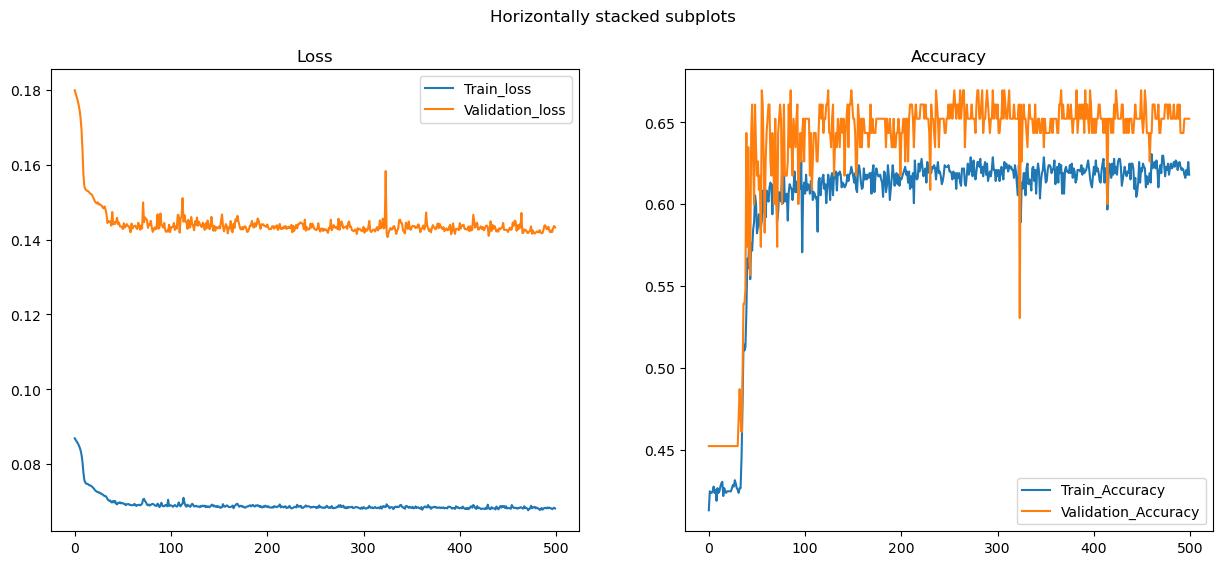

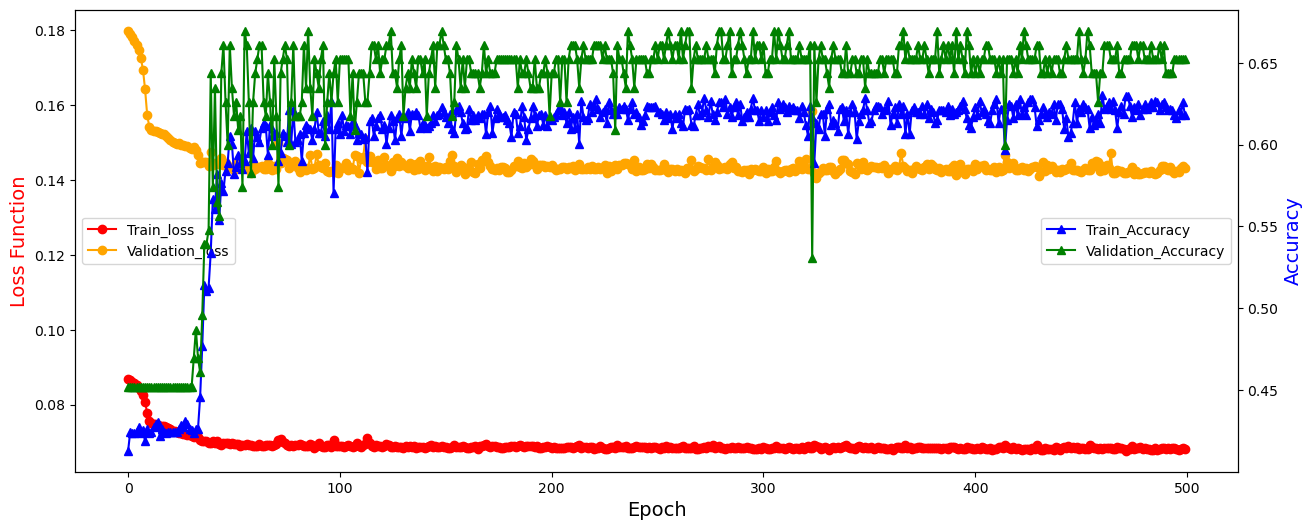

Current time: 149.653 minutes. Time expected till completion: 0.000 minutes
Finished training in: 149.653 minutes


In [15]:
#loader = train_loader # Use the train loader to train
#loader2 = valid_loader
# Main
train_loss, val_loss = [], []
train_accuracy, val_accuracy = [], []

val_loss_withDataAug, val_accuracy_withDataAug = [], []

# Load checkpoints
names = os.listdir(model_checkpoints)
for elem in names:
    if(elem=="metrics_losss_accuracy.csv"):
        print("Loading Metrics")
        dd = pd.read_csv(model_checkpoints + "metrics_losss_accuracy.csv")
        train_loss = dd["train_loss"].tolist()
        val_loss = dd["val_loss"].tolist()
        train_accuracy = dd["train_accuracy"].tolist()
        val_accuracy = dd["val_accuracy"].tolist()
        
# count time
start = time.time()
#PyTorch - Training the Model
for epoch in range(epoch_check, epochs):
    print()
    # Print current epoch
    print(f"Epoch {epoch + 1} of {epochs}")
    
    # Train model
    modelpy.train()
    running_loss=0
    total=0
    correct=0
    # loop for every training batch (one epoch)
    for bi, data in tqdm(enumerate(train_loader), total=len(train_loader)): # use tqdm package to track running time
        # Get the tensors
        images = data[0].to(device)# use the gpu
        labels = data[1].to(device)# use the gpu
        
        # in pytorch you have assign the zero for gradien in any sub epoch
        #optim.zero_grad()
        #create the output from the CNN base on the give batch images
        out = modelpy(images)
        # count the loss function 
        loss = criterion(out, labels)
        
        ######################
        optim.zero_grad()#################
        ######################
        # count the backpropagation
        loss.backward()
        # learning
        optim.step()
        
        # add new value to the main loss
        running_loss += loss.item()
        
        # calculate accuracy
        predictions = torch.argmax(out, dim=1)
        total += labels.size(0)
        correct +=(predictions == labels).sum().item()
        
        
    train_epoch_loss = running_loss/len(train_loader.dataset)
    
    train_epoch_accuracy = correct/total
    
    modelpy.eval()
    running_loss = 0.0
    correct=0
    total=0
    with torch.no_grad():
        for bi, data in tqdm(enumerate(valid_loader), total=len(valid_loader)):
            # Get the tensors
            images = data[0].to(device)# use the gpu
            label = data[1].to(device)# use the gpu
            
            #create the output from the CNN base on the give batch images
            outputs = modelpy(images)
            # count the loss function
            loss = criterion(outputs, label)
            
            # Add loss of each item (total items in a batch = batch size) .
            running_loss += loss.item()
            
            # calculate accuracy
            predictions = torch.argmax(outputs, dim=1)
            total += label.size(0)
            correct +=(predictions == label).sum().item()
            
            
    val_epoch_loss = running_loss/len(valid_loader.dataset) 
    val_epoch_accuracy = correct/total

    
    
    print("train loss: ", train_epoch_loss)
    print("Val loss: ", val_epoch_loss)
    print("train accuracy: ", train_epoch_accuracy)
    print("Val accuracy: ", val_epoch_accuracy)

    
    
    # save results
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_accuracy.append(val_epoch_accuracy)

    
    # Save model with all information every 100 epochs. Can be used 
    # resuming training. optim
    if (epoch+1) % checkpoints_save == 0: # checkpoints_save
        # Save Model
        print("Saving model checkpoint")
        end = time.time()
        time_elapsed = (end-start)+previous_time
        save_model(epoch, time_elapsed, modelpy, optim, criterion, path = model_checkpoints + "model_ckpt.pth")
        # save the metrics
        save_metrics(train_loss, val_loss, train_accuracy, val_accuracy, path = model_checkpoints + "metrics_losss_accuracy.csv")
        
        # save model at epoch
        save_model(epoch, time_elapsed, modelpy, optim, criterion, path = model_checkpoints + "model_ckpt_"+str(epoch+1)+".pth")
        
        # Cheack the evolution at this point
        plot_loss_accuracy(train_loss, val_loss, train_accuracy, val_accuracy)
        
        
    ep_time = time.time()
    print(f"Current time: {(((ep_time-start)+previous_time)/60):.3f} minutes. Time expected till completion: {(((((ep_time-start)+previous_time)/(epoch + 1)) * (epochs-(epoch + 1)))/60):.3f} minutes")
    
end = time.time()
print(f"Finished training in: {(((end-start)+previous_time)/60):.3f} minutes") 

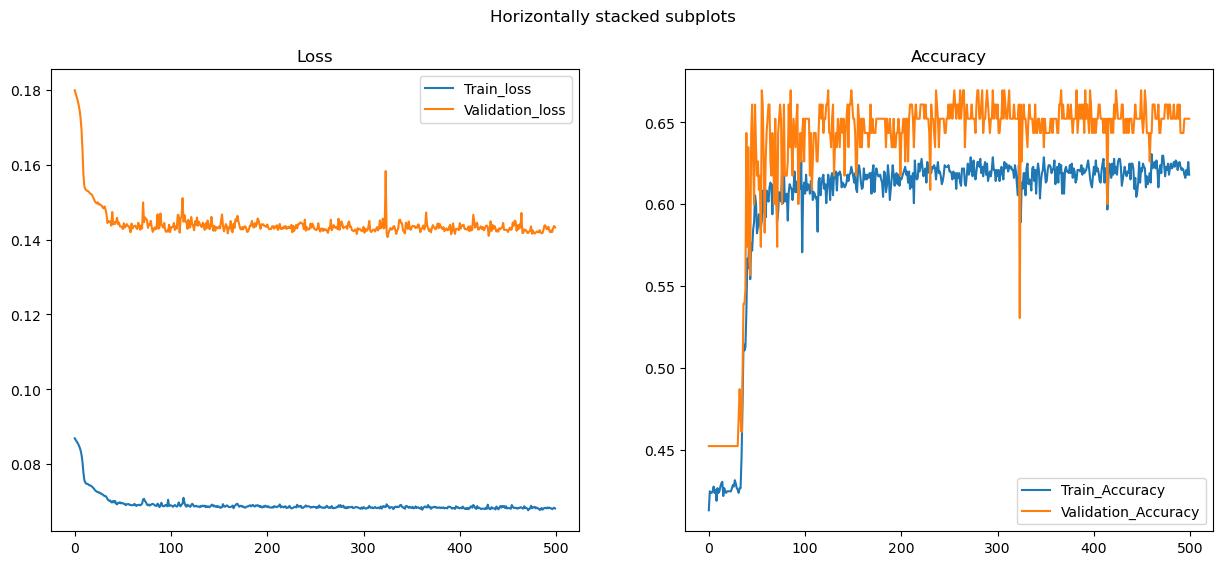

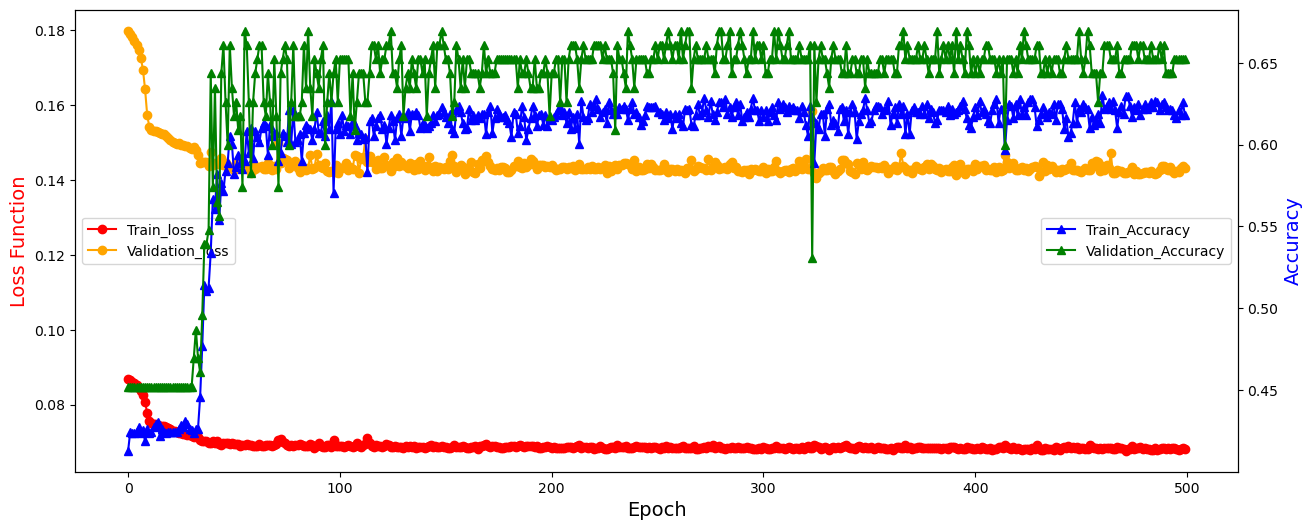

In [16]:
plot_loss_accuracy(train_loss, val_loss, train_accuracy, val_accuracy)

### Save Model

In [17]:
torch.save(modelpy.state_dict(), model_checkpoints + "saved_model_state_dict.pt")
torch.save(modelpy, model_checkpoints + "saved_model.pt")

# 3. Evaluate your model using the developed software

In [18]:
# Calculate accuracy for Validation and Train sets
accuracy_given_set(modelpy, train_loader, device, name="Train")
accuracy_given_set(modelpy, valid_loader, device, name="Validation")

Accuracy of the network on the 1034 Train instances: 62.86266924564797%
Accuracy of the network on the 115 Validation instances: 65.21739130434783%


In [19]:
# Import the test dataset
size_of_resized_img = (224,224) 
test_data, test_names = import_test_folder_dataset_2(test_data_path, resized_side=size_of_resized_img)
print("Dim of Data: ", test_data.shape)
print("Dim of Lables: ", test_names.shape)

Dim of Data:  (380, 224, 224, 3)
Dim of Lables:  (380,)


In [20]:
# Create the dataset object
test_Dataset = Data_test_2(test_data, test_names, img_transform_val)#img_transform_val
print("Test len: ",len(test_Dataset))

Test len:  380


In [21]:
# Make the predictions for the test dataset
predictions_list, names = make_predictions(modelpy=modelpy, dataset=test_Dataset, device=device)
len(predictions_list)

380

In [22]:
# Save the Predictions
save_predictions_as_csv(names=names, predictions=predictions_list, name="08_10Conv_0Res_128FChannels_0Batch.csv")

# 4. Compare results with [SCTL paper](https://www.mdpi.com/2076-2615/12/7/886/htm). Requirement: performance is better than VGG16: 66.8%

# 5. Write a four-page paper report using the shared LaTex template. Upload your paper to ResearchGate or Arxiv, and put your paper link here.

# 6. Grading rubric

(1). Code ------- 20 points (you also need to upload your final model as a pt file)

(2). Grammer ---- 20 points

(3). Introduction & related work --- 10 points

(4). Method  ---- 20 points

(5). Results ---- 20 points

(6). Discussion - 10 points